# Neural Belief Propagation Decoding of Quantum LDPC Codes Using Overcomplete Check Matrices
## Sisi Miao, Alexander Schnerring, Haizheng Li, and Laurent Schmalen

The recent success in constructing asymptotically good quantum low-density parity-check (QLDPC) codes makes this family of codes a promising candidate for error-correcting schemes in quantum computing. However, conventional belief propagation (BP) decoding of QLDPC codes does not yield satisfying performance due to the presence of unavoidable short cycles in their Tanner graph and the special degeneracy phenomenon. In this work, we propose to decode QLDPC codes based on a check matrix with redundant rows, generated from linear combinations of the rows in the original check matrix. This approach yields a significant improvement in decoding performance with the additional advantage of very low decoding latency. Furthermore, we propose a novel neural belief propagation decoder based on the quaternary BP decoder of QLDPC codes which leads to further decoding performance improvements.

This jupyter notebook provides the implementation which produces the results in [1]. In specific, this notebook contains:
* The neural BP(NBP) decoder
* The function for training, can be run on CPU or GPU
* Call on the C++ functions which evaluate the trained decoder
* Addtionally, the overcomplete check matrices used in [1] are provided in the ./PCM folder

[1] S. Miao, A. Schnerring, H. Li and L. Schmalen, "Neural belief propagation decoding of quantum LDPC codes using overcomplete check matrices," Proc. IEEE Inform. Theory Workshop (ITW), Saint-Malo, France, Apr. 2023, https://arxiv.org/abs/2212.10245

This work has received funding from the European Research Council (ERC) under the European Union's Horizon 2020 research and innovation programme (grant agreement No. 101001899).

The code in this file: Copyright 2023 Sisi Miao, Communications Engineering Lab @ KIT.

This source code is supplied under [MIT License](https://github.com/kit-cel/Quantum-Neural-BP4-demo/blob/master/LICENSE.md).

In [11]:
#Import external libraries
import torch
import sys
import torch.nn as nn
import numpy as np
import os
from tqdm import tqdm
import random
import matplotlib.pylab as plt

In [18]:
class NBP_oc(nn.Module):
    def __init__(self, n: int, k: int, m: int, m1: int, m2: int, codeType: str, n_iterations: int,
                 folder_weights: str = None,
                 batch_size: int = 1):
        super().__init__()
        self.name = "Neural_BP_Decoder"
        self.batch_size = batch_size
        self.codeType = codeType
        self.n = n # physical qubit の数
        self.k = k # logical qubit の数
        #m_oc is the number rows of the overcomplete check matrix
        self.m_oc = m
        self.m1 = m1
        self.m2 = m2
        #m is the number of rows of the full rank check matrix
        self.m = n - k
        #If True, then all outgoing edges on the same CN has the same weight, configurable
        self.one_weight_per_cn = True
        self.rate = self.k / self.n
        self.n_iterations = n_iterations # BP の iter数
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.xhat = torch.zeros((batch_size, self.n))
        self.zhat = torch.zeros((batch_size, self.n))
        self.load_matrices()

        if not folder_weights:
            #initilize weights with 1 if none given
            self.ini_weight_as_one(n_iterations)
        else:
            # load pretrained weights stored in directory "folder":
            self.load_weights(folder_weights, self.device)

    def fx(self, a: torch.tensor, b: torch.tensor) -> torch.Tensor:
        # ln(exp(x)+exp(y)) = max(x,y)+ln(1+exp(-|x-y|)
        return torch.max(a, b) + self.log1pexp(-1 * torch.abs(a - b))

    def log1pexp(self, x):
        # more stable version of log(1 + exp(x))
        m = nn.Softplus(beta=1, threshold=50)
        return m(x)

    def calculate_self_syn(self):
        # Hz と errorx の積で良い？
        # errorx, errorz: (batch_size, n)
        # Hx, Hz: (1, m1 or m2, n)
        # synx, synz: (batch_size, m1 or m2, 1)
        
        self.synx = torch.matmul(self.Hz, torch.transpose(self.errorx, 0, 1)) # transpose: 軸を入れ替える
        self.synz = torch.matmul(self.Hx, torch.transpose(self.errorz, 0, 1))
        self.synx = torch.remainder(torch.transpose(self.synx, 2, 0), 2) # remainder: 余り
        self.synz = torch.remainder(torch.transpose(self.synz, 2, 0), 2)
        return torch.cat((self.synz, self.synx), dim=1)

    def loss(self, Gamma) -> torch.Tensor:
        """loss functions proposed in [1] eq. 11"""

        # first row, anti-commute with X, second row, anti-commute with Z, [1] eq. 10
        # 1列目、Xとのアンチコミュート、2列目、Zとのアンチコミュート [1] 式10
        prob = torch.sigmoid(-1.0 * Gamma).float()

        prob_aX = prob[:, 0, :]
        prob_aZ = prob[:, 1, :]

        assert not torch.isinf(prob_aX).any()
        assert not torch.isinf(prob_aZ).any()
        assert not torch.isnan(prob_aX).any()
        assert not torch.isnan(prob_aZ).any()

        #Depend on if the error commute with the entries in S_dual, which is denoted as G here
        #CSS constructions gives the simplification that Gx contains only X entries, and Gz contains on Z
        #誤差がS_dualのエントリと一致するかどうかに依存する。
        #GxはXの項目のみを含み、GzはZの項目のみを含む。
        correctionx = torch.zeros_like(self.errorx)
        correctionz = torch.zeros_like(self.errorz)

        correctionz[self.qx == 1] = prob_aX[self.qx == 1]
        correctionz[self.qz == 1] = 1 - prob_aX[self.qz == 1]
        correctionz[self.qy == 1] = 1 - prob_aX[self.qy == 1]
        correctionz[self.qi == 1] = prob_aX[self.qi == 1]

        correctionx[self.qz == 1] = prob_aZ[self.qz == 1]
        correctionx[self.qx == 1] = 1 - prob_aZ[self.qx == 1]
        correctionx[self.qy == 1] = 1 - prob_aZ[self.qy == 1]
        correctionx[self.qi == 1] = prob_aZ[self.qi == 1]

        #first summ up the probability of anti-commute for all elements in each row of G
        #まず、Gの各行の全要素について、アンチコミュートの確率を合計する。
        synx = torch.matmul(self.Gz, torch.transpose(correctionx.float(), 0, 1))
        synz = torch.matmul(self.Gx, torch.transpose(correctionz.float(), 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        syn_real = torch.cat((synz, synx), dim=1)

        #the take the sin function, then summed up for all rows of G
        #sin関数をとり、Gのすべての行について合計する。
        loss = torch.zeros(1, self.batch_size)
        for b in range(self.batch_size):
            loss[0, b] = torch.sum(torch.abs(torch.sin(np.pi / 2 * syn_real[b, :, :])))

        assert not torch.isnan(loss).any()
        assert not torch.isinf(loss).any()

        return loss

    def variable_node_update(self, incoming_messages, llr, weights_vn, weights_llr):
        # As we deal with CSS codes, all non-zero entries on the upper part anti-commute with Z and Y and commute with X
        # all non-zero entries on the upper part anti-commute with X and Y and commute with Z
        # Then the calculation can be done in matrices => speed up training (probably)
        # CSSコードを扱うので、上部の非ゼロエントリーはすべてZとYと反共約し、Xと共約する。
        # 上部のすべての非ゼロエントリは X および Y と反共約し、Z と共約する。
        # すると計算は行列でできる => トレーニングのスピードアップ（たぶん）
        incoming_messages_upper = incoming_messages[:, 0:self.m1, :]
        incoming_messages_lower = incoming_messages[:, self.m1:self.m_oc, :]
        incoming_messages_upper.to(self.device)
        incoming_messages_lower.to(self.device)

        Gammaz = llr * weights_llr + torch.sum(incoming_messages_upper, dim=1, keepdim=True)
        Gammax = llr * weights_llr + torch.sum(incoming_messages_lower, dim=1, keepdim=True)
        Gammay = llr * weights_llr + torch.sum(incoming_messages, dim=1, keepdim=True)

        Gammaz.double().to(self.device)
        Gammax.double().to(self.device)
        Gammay.double().to(self.device)
        
        #can be re-used for hard-decision in decoding, but not used in training as we don't check for decoding success
        #we are only interested in the loss during training
        #デコード時のハード判定に再利用できるが、デコードの成功をチェックしないため、トレーニングでは使用しない。
        #我々はトレーニング中の損失にしか興味がない。
        Gamma = torch.cat((Gammay, Gammax, Gammaz), dim=1).to(self.device)
        print(Gamma)

        assert not torch.isinf(Gammaz).any()
        assert not torch.isinf(Gammax).any()
        assert not torch.isinf(Gammay).any()

        
        outgoing_messages_upper = self.log1pexp(-1.0 * Gammax) - self.fx(-1.0 * Gammaz, -1.0 * Gammay)
        outgoing_messages_lower = self.log1pexp(-1.0 * Gammaz) - self.fx(-1.0 * Gammax, -1.0 * Gammay)
        Gamma_all = torch.cat((outgoing_messages_upper, outgoing_messages_lower), dim=1).to(self.device)

        outgoing_messages_upper = outgoing_messages_upper * self.Hx
        outgoing_messages_lower = outgoing_messages_lower * self.Hz
        outgoing_messages = torch.cat((outgoing_messages_upper, outgoing_messages_lower), dim=1)

        outgoing_messages = outgoing_messages - incoming_messages
        outgoing_messages = outgoing_messages * self.H

        assert not torch.isinf(Gammaz).any()
        assert not torch.isinf(Gammax).any()
        assert not torch.isinf(Gammay).any()

        #to avoid numerical issues
        #数値的な問題を避けるため
        outgoing_messages = torch.clip(outgoing_messages, -30.0, 30.0)

        return outgoing_messages.float() * weights_vn, Gamma, Gamma_all

    def check_node_update(self, incoming_messages: torch.Tensor, weights_cn: torch.Tensor) -> torch.Tensor:
        multipicator = torch.pow(-1, self.syn)
        multipicator = multipicator * self.H

        # use the simplification with the phi function to turn multipilication to addtion
        # a bit more troublesome than the usual SPA, because want to do it in matrix
        # 乗算を加算に変えるために phi 関数を使った単純化を使う
        # 通常の SPA よりも少し面倒である。
        incoming_messages_sign = torch.sign(incoming_messages) # torch.sign: 1. or -1. or 0. を返す
        incoming_messages_sign[incoming_messages == 0] = 1
        first_part = torch.prod(incoming_messages_sign, dim=2, keepdim=True) # 要素の積をとって 2 番目の次元を削除する
        first_part = first_part * self.H
        first_part = first_part / incoming_messages_sign
        first_part = self.H * first_part
        assert not torch.isinf(first_part).any()
        assert not torch.isnan(first_part).any()

        incoming_messages_abs = torch.abs(incoming_messages).double()
        helper = torch.ones_like(incoming_messages_abs)
        helper[incoming_messages_abs == 0] = 0
        incoming_messages_abs[incoming_messages == 0] = 1.0

        phi_incoming_messages = -1.0 * torch.log(torch.tanh(incoming_messages_abs / 2.0))
        phi_incoming_messages = phi_incoming_messages * helper
        phi_incoming_messages = phi_incoming_messages * self.H

        temp = torch.sum(phi_incoming_messages, dim=2, keepdim=True)
        Aij = temp * self.H

        sum_msg = Aij - phi_incoming_messages
        helper = torch.ones_like(sum_msg)
        helper[sum_msg == 0] = 0
        sum_msg[sum_msg == 0] = 1.0

        second_part = -1 * torch.log(torch.tanh(sum_msg / 2.0))
        second_part = second_part * helper
        second_part = second_part * self.H
        assert not torch.isinf(second_part).any()
        assert not torch.isnan(second_part).any()

        outgoing_messages = first_part * second_part
        outgoing_messages = outgoing_messages * multipicator

        outgoing_messages = (outgoing_messages * weights_cn).float()
        return outgoing_messages

    def forward(self, errorx: torch.Tensor, errorz: torch.Tensor, ep: float, batch_size=1) -> torch.Tensor:
        """main decoding procedure"""
        loss_array = torch.zeros(self.batch_size, self.n_iterations).float().to(self.device)
        
        # batch_size != self.batch_size のときに例外を投げる
        assert batch_size == self.batch_size

        self.errorx = errorx.to(self.device)
        self.errorz = errorz.to(self.device)

        # 4 次信念伝播なので 4 変数
        self.qx = torch.zeros_like(self.errorx)
        self.qz = torch.zeros_like(self.errorx)
        self.qy = torch.zeros_like(self.errorx)
        self.qi = torch.ones_like(self.errorx)

        # x エラーの箇所を 1 にしてから, z エラーがある箇所 (y エラー) を除く
        self.qx[self.errorx == 1] = 1
        self.qx[self.errorz == 1] = 0

        # z エラーの箇所を 1 にしてから, x エラーがある箇所 (y エラー) を除く
        self.qz[self.errorz == 1] = 1
        self.qz[self.errorx == 1] = 0

        # 一旦 z エラーの箇所を y エラーとしてから, x エラーが無い箇所を除く
        self.qy[self.errorz == 1] = 1
        self.qy[self.errorx != self.errorz] = 0

        # qi は初め 1 で初期化していることに注意
        # エラーのある箇所を除く
        self.qi[self.errorx == 1] = 0
        self.qi[self.errorz == 1] = 0

        self.syn = self.calculate_self_syn()

        #initial LLR to, first equation in [1,Sec.II-C]
        llr = np.log(3 * (1 - ep) / ep)

        messages_cn_to_vn = torch.zeros((batch_size, self.m_oc, self.n)).to(self.device)
        self.batch_size = batch_size

        # initlize VN message
        messages_vn_to_cn, _, _ = self.variable_node_update(messages_cn_to_vn, llr, self.weights_vn[0],
                                                            self.weights_llr[0])

        # iteratively decode, decode will continue till the max. iteration, even if the syndrome already matched
        # 反復デコードでは、シンドロームがすでにマッチしていても、デコードは最大反復まで続けられる。
        for i in range(self.n_iterations):

            assert not torch.isnan(self.weights_llr[i]).any()
            assert not torch.isnan(self.weights_cn[i]).any()
            assert not torch.isnan(messages_cn_to_vn).any()

            # check node update:
            messages_cn_to_vn = self.check_node_update(messages_vn_to_cn, self.weights_cn[i])

            assert not torch.isnan(messages_cn_to_vn).any()
            assert not torch.isinf(messages_cn_to_vn).any()

            # variable node update:
            messages_vn_to_cn, Tau, Tau_all = self.variable_node_update(messages_cn_to_vn, llr, self.weights_vn[i + 1],
                                                                        self.weights_llr[i + 1])

            assert not torch.isnan(messages_vn_to_cn).any()
            assert not torch.isinf(messages_vn_to_cn).any()
            assert not torch.isnan(Tau).any()
            assert not torch.isinf(Tau).any()

            loss_array[:, i] = self.loss(Tau_all)


        _, minIdx = torch.min(loss_array, dim=1, keepdim=False)


        loss = torch.zeros(self.batch_size, ).float().to(self.device)
        #take average of the loss for the first iterations till the loss is minimized
        #損失が最小になるまでの、最初の反復の損失の平均をとる。
        for b in range(batch_size):
            for idx in range(minIdx[b] + 1):
                loss[b] += loss_array[b, idx]
            loss[b] /= (minIdx[b] + 1)

        loss = torch.sum(loss, dim=0) / self.batch_size

        assert not torch.isnan(loss)
        assert not torch.isinf(loss)
        return loss
    
    
    def check_syndrome(self, Tau):
        """performs hard decision to give the estimated error and check for decoding success.
        However, not used in the current script, as we are only performing trainig"""
        """推定誤差を与えるハード判定を行い、デコードの成功をチェックする。
        しかし、今回のスクリプトでは学習のみを行うため、使用しない。"""
        tmp = torch.zeros(self.batch_size, 1, self.n).to(self.device)
        Tau = torch.cat((tmp, Tau), dim=1)

        minVal, minIdx = torch.min(Tau, dim=1, keepdim=False)

        self.xhat = torch.zeros((self.batch_size, self.n)).to(self.device)
        self.zhat = torch.zeros((self.batch_size, self.n)).to(self.device)

        self.xhat[minIdx == 1] = 1
        self.xhat[minIdx == 2] = 1

        self.zhat[minIdx == 1] = 1
        self.zhat[minIdx == 3] = 1
        m = torch.nn.ReLU()

        synx = torch.matmul(self.Hz, torch.transpose(self.xhat, 0, 1))
        synz = torch.matmul(self.Hx, torch.transpose(self.zhat, 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        synhat = torch.remainder(torch.cat((synz, synx), dim=1), 2)

        syn_match = torch.all(torch.all(torch.eq(self.syn, synhat), dim=1), dim=1)

        correctionx = torch.remainder(self.xhat + self.errorx, 2)
        correctionz = torch.remainder(self.zhat + self.errorz, 2)
        synx = torch.matmul(self.Gz, torch.transpose(correctionx, 0, 1))
        synz = torch.matmul(self.Gx, torch.transpose(correctionz, 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        self.syn_real = torch.cat((synz, synx), dim=1)

        syn_real = torch.remainder(self.syn_real, 2)
        tmmp = torch.sum(syn_real, dim=1, keepdim=False)
        success = torch.all(torch.eq(torch.sum(syn_real, dim=1, keepdim=False), 0), dim=1)
        return syn_match, success
    
    
    
    def unsqueeze_batches(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Checks if tensor is 2D or 3D. If tensor is 2D, insert extra dimension (first dimension)
        This method can be used to allow decoding of
            batches of codewords (batch size, m, n)
            as well as single codewords (m, n)
        """
        """
        テンソルが2次元か3次元かを調べる。テンソルが2Dの場合、余分な次元（1次元目）を挿入する。
        このメソッドは
            コードワードのバッチ(バッチサイズ、m, n)
            単一のコードワード(m, n)と同様に
        """
        if tensor.dim() == 3:
            return tensor
        elif tensor.dim() == 2:
            return torch.unsqueeze(tensor, dim=0)

    #continue with the NBP_oc class, some tool functions
    #NBP_ocクラスを継続し、いくつかのツール機能を追加する。
    def load_matrices(self):
        """reads in the check matrix for decoding as well as the dual matrix for checking decoding success"""
        """デコードのためのチェックマトリックスと、デコードの成功をチェックするためのデュアルマトリックスを読み込む"""
        file_nameGx = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_Gx.alist"
        file_nameGz = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_Gz.alist"
        Gx = readAlist(file_nameGx)
        Gz = readAlist(file_nameGz)

        file_nameH = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_H_" + str(self.m_oc) + ".alist"

        H = readAlist(file_nameH)
        self.H = H
        Hx = H[0:self.m1, :]
        Hz = H[self.m1:self.m_oc, :]
        Gx = torch.from_numpy(Gx).float()
        Gz = torch.from_numpy(Gz).float()
        Hx = torch.from_numpy(Hx).float()
        Hz = torch.from_numpy(Hz).float()


        # first dim for batches.
        self.Hx = self.unsqueeze_batches(Hx).float().to(self.device)
        self.Hz = self.unsqueeze_batches(Hz).float().to(self.device)
        self.Gx = self.unsqueeze_batches(Gx).float().to(self.device)
        self.Gz = self.unsqueeze_batches(Gz).float().to(self.device)

        self.H = torch.cat((self.Hx, self.Hz), dim=1).float().to(self.device)
        self.H_reverse = 1 - self.H

    def ini_weight_as_one(self, n_iterations: int):
        """this function can be configured to determine which parameters are trainable"""
        """この関数は、どのパラメーターが訓練可能かを決定するために設定することができる"""
        self.weights_llr = [] # log-likelihood ratio
        self.weights_cn = []
        self.weights_vn = []
        for i in range(n_iterations):
            if self.one_weight_per_cn:
                self.weights_cn.append(torch.ones((1, self.m_oc, 1), requires_grad=True, device=self.device))
            else:
                self.weights_cn.append(torch.ones((1, self.m_oc, self.n), requires_grad=True, device=self.device))
            self.weights_llr.append(torch.ones((1, 1, self.n), requires_grad=True, device=self.device))
            self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=False, device=self.device))
        self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=False, device=self.device))
        self.weights_llr.append(torch.ones((1, 1, self.n), requires_grad=True, device=self.device))

    def save_weights(self):
        """weights are saved twice, once as .pt for python, once as .txt for c++"""
        """重みは2回保存されます。1回はpython用の.ptとして、もう1回はc++用の.txtとして保存されます"""
        "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/"
        os.makedirs(path, exist_ok=True)
        #some parameters may not be trained, but we save them anyway
        file_vn = "weights_vn.pt"
        file_cn = "weights_cn.pt"
        file_llr = "weights_llr.pt"

        torch.save(self.weights_vn, os.path.join(path, file_vn))
        torch.save(self.weights_cn, os.path.join(path, file_cn))
        torch.save(self.weights_llr, os.path.join(path, file_llr))
        print(f'  weights saved to {file_cn},{file_vn}, and {file_llr}.\n')

        # the following codes save the weights into txt files, which is used for C++ code for evaluating the trained
        # decoder. So the C++ codes don't need to mess around with python packages
        # not very elegant but will do for now
        # 以下のコードは重みをtxtファイルに保存する。
        # C++ コードに使用される。そのため、C++のコードはpythonのパッケージをいじる必要がない。
        # あまりエレガントではないが、今のところはこれで十分だろう
        if sys.version_info[0] == 2:
            import cStringIO
            StringIO = cStringIO.StringIO
        else:
            import io

        StringIO = io.StringIO

        # write llr weights, easy
        f = open(path + "weight_llr.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_llr)))
            for i in self.weights_llr:
                data = i.detach().cpu().numpy().reshape(self.n, 1)
                opt = ["%.16f" % i for i in data]
                output.write(' '.join(opt))
                output.write('\n')
            f.write(output.getvalue())
        f.close()

        # write CN weights
        H_tmp = self.H.detach().cpu().numpy().reshape(self.m_oc, self.n)
        H_tmp = np.array(H_tmp, dtype='int')
        f = open(path + "weight_cn.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_cn)))
            nRows, nCols = H_tmp.shape
            # first line: matrix dimensions
            output.write('{} {}\n'.format(nCols, nRows))

            # next three lines: (max) column and row degrees
            colWeights = H_tmp.sum(axis=0)
            rowWeights = H_tmp.sum(axis=1)

            maxRowWeight = max(rowWeights)

            if self.one_weight_per_cn:
                # column-wise nonzeros block
                for i in self.weights_cn:
                    matrix = i.detach().cpu().numpy().reshape(self.m_oc, 1)
                    for rowId in range(nRows):
                        opt = ["%.16f" % i for i in matrix[rowId]]
                        for i in range(rowWeights[rowId].astype('int') - 1):
                            output.write(opt[0])
                            output.write(' ')
                        output.write(opt[0])
                        # fill with zeros so that every line has maxDegree number of entries
                        output.write(' 0' * (maxRowWeight - rowWeights[rowId] - 1).astype('int'))
                        output.write('\n')
            else:
                # column-wise nonzeros block
                for i in self.weights_cn:
                    matrix = i.detach().cpu().numpy().reshape(self.m_oc, self.n)
                    matrix *= self.H[0].detach().cpu().numpy().reshape(self.m_oc, self.n)
                    for rowId in range(nRows):
                        nonzeroIndices = np.flatnonzero(matrix[rowId, :])  # AList uses 1-based indexing
                        output.write(' '.join(map(str, matrix[rowId, nonzeroIndices])))
                        # fill with zeros so that every line has maxDegree number of entries
                        output.write(' 0' * (maxRowWeight - len(nonzeroIndices)))
                        output.write('\n')
            f.write(output.getvalue())
        f.close()

        # write VN weights
        H_tmp = self.H.detach().cpu().numpy().reshape(self.m_oc, self.n)
        H_tmp = np.array(H_tmp, dtype='int')
        f = open(path + "weight_vn.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_vn)))
            nRows, nCols = H_tmp.shape
            # first line: matrix dimensions
            output.write('{} {}\n'.format(nCols, nRows))

            # next three lines: (max) column and row degrees
            colWeights = H_tmp.sum(axis=0)
            rowWeights = H_tmp.sum(axis=1)

            maxColWeight = max(colWeights)

            # column-wise nonzeros block
            for i in self.weights_vn:
                matrix = i.detach().cpu().numpy().reshape(self.m_oc, self.n)
                matrix *= self.H[0].detach().cpu().numpy().reshape(self.m_oc, self.n)
                for colId in range(nCols):
                    nonzeroIndices = np.flatnonzero(matrix[:, colId])  # AList uses 1-based indexing
                    output.write(' '.join(map(str, matrix[nonzeroIndices, colId])))
                    # fill with zeros so that every line has maxDegree number of entries
                    output.write(' 0' * (maxColWeight - len(nonzeroIndices)))
                    output.write('\n')
            f.write(output.getvalue())
        f.close()

In [13]:
class BP_oc(nn.Module):
    def __init__(self, n: int, k: int, m: int, m1: int, m2: int, codeType: str, n_iterations: int,
                 folder_weights: str = None,
                 batch_size: int = 1):
        super().__init__()
        self.name = "BP_Decoder"
        self.batch_size = batch_size
        self.codeType = codeType
        self.n = n # physical qubit の数
        self.k = k # logical qubit の数
        #m_oc is the number rows of the overcomplete check matrix
        self.m_oc = m
        self.m1 = m1
        self.m2 = m2
        #m is the number of rows of the full rank check matrix
        self.m = n - k
        #If True, then all outgoing edges on the same CN has the same weight, configurable
        self.one_weight_per_cn = True
        self.rate = self.k / self.n
        self.n_iterations = n_iterations # BP の iter数
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.xhat = torch.zeros((batch_size, self.n))
        self.zhat = torch.zeros((batch_size, self.n))
        self.load_matrices()

        if not folder_weights:
            #initilize weights with 1 if none given
            self.ini_weight_as_one(n_iterations)
        else:
            # load pretrained weights stored in directory "folder":
            self.load_weights(folder_weights, self.device)

    def fx(self, a: torch.tensor, b: torch.tensor) -> torch.Tensor:
        # ln(exp(x)+exp(y)) = max(x,y)+ln(1+exp(-|x-y|)
        return torch.max(a, b) + self.log1pexp(-1 * torch.abs(a - b))

    def log1pexp(self, x):
        # more stable version of log(1 + exp(x))
        m = nn.Softplus(beta=1, threshold=50)
        return m(x)

    def calculate_self_syn(self):
        # Hz と errorx の積で良い？
        self.synx = torch.matmul(self.Hz, torch.transpose(self.errorx, 0, 1)) # transpose: 軸を入れ替える
        self.synz = torch.matmul(self.Hx, torch.transpose(self.errorz, 0, 1))
        self.synx = torch.remainder(torch.transpose(self.synx, 2, 0), 2) # remainder: 余り
        self.synz = torch.remainder(torch.transpose(self.synz, 2, 0), 2)
        return torch.cat((self.synz, self.synx), dim=1)

    def loss(self, Gamma) -> torch.Tensor:
        """loss functions proposed in [1] eq. 11"""

        # first row, anti-commute with X, second row, anti-commute with Z, [1] eq. 10
        # 1列目、Xとのアンチコミュート、2列目、Zとのアンチコミュート [1] 式10
        prob = torch.sigmoid(-1.0 * Gamma).float()

        prob_aX = prob[:, 0, :]
        prob_aZ = prob[:, 1, :]

        assert not torch.isinf(prob_aX).any()
        assert not torch.isinf(prob_aZ).any()
        assert not torch.isnan(prob_aX).any()
        assert not torch.isnan(prob_aZ).any()

        #Depend on if the error commute with the entries in S_dual, which is denoted as G here
        #CSS constructions gives the simplification that Gx contains only X entries, and Gz contains on Z
        #誤差がS_dualのエントリと一致するかどうかに依存する。
        #GxはXの項目のみを含み、GzはZの項目のみを含む。
        correctionx = torch.zeros_like(self.errorx)
        correctionz = torch.zeros_like(self.errorz)

        correctionz[self.qx == 1] = prob_aX[self.qx == 1]
        correctionz[self.qz == 1] = 1 - prob_aX[self.qz == 1]
        correctionz[self.qy == 1] = 1 - prob_aX[self.qy == 1]
        correctionz[self.qi == 1] = prob_aX[self.qi == 1]

        correctionx[self.qz == 1] = prob_aZ[self.qz == 1]
        correctionx[self.qx == 1] = 1 - prob_aZ[self.qx == 1]
        correctionx[self.qy == 1] = 1 - prob_aZ[self.qy == 1]
        correctionx[self.qi == 1] = prob_aZ[self.qi == 1]

        #first summ up the probability of anti-commute for all elements in each row of G
        #まず、Gの各行の全要素について、アンチコミュートの確率を合計する。
        synx = torch.matmul(self.Gz, torch.transpose(correctionx.float(), 0, 1))
        synz = torch.matmul(self.Gx, torch.transpose(correctionz.float(), 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        syn_real = torch.cat((synz, synx), dim=1)

        #the take the sin function, then summed up for all rows of G
        #sin関数をとり、Gのすべての行について合計する。
        loss = torch.zeros(1, self.batch_size)
        for b in range(self.batch_size):
            loss[0, b] = torch.sum(torch.abs(torch.sin(np.pi / 2 * syn_real[b, :, :])))

        assert not torch.isnan(loss).any()
        assert not torch.isinf(loss).any()

        return loss

    def variable_node_update(self, incoming_messages, llr, weights_vn, weights_llr):
        # As we deal with CSS codes, all non-zero entries on the upper part anti-commute with Z and Y and commute with X
        # all non-zero entries on the upper part anti-commute with X and Y and commute with Z
        # Then the calculation can be done in matrices => speed up training (probably)
        # CSSコードを扱うので、上部の非ゼロエントリーはすべてZとYと反共約し、Xと共約する。
        # 上部のすべての非ゼロエントリは X および Y と反共約し、Z と共約する。
        # すると計算は行列でできる => トレーニングのスピードアップ（たぶん）
        incoming_messages_upper = incoming_messages[:, 0:self.m1, :]
        incoming_messages_lower = incoming_messages[:, self.m1:self.m_oc, :]
        incoming_messages_upper.to(self.device)
        incoming_messages_lower.to(self.device)

        Gammaz = llr * weights_llr + torch.sum(incoming_messages_upper, dim=1, keepdim=True)
        Gammax = llr * weights_llr + torch.sum(incoming_messages_lower, dim=1, keepdim=True)
        Gammay = llr * weights_llr + torch.sum(incoming_messages, dim=1, keepdim=True)

        Gammaz.double().to(self.device)
        Gammax.double().to(self.device)
        Gammay.double().to(self.device)
        
        #can be re-used for hard-decision in decoding, but not used in training as we don't check for decoding success
        #we are only interested in the loss during training
        #デコード時のハード判定に再利用できるが、デコードの成功をチェックしないため、トレーニングでは使用しない。
        #我々はトレーニング中の損失にしか興味がない。
        Gamma = torch.cat((Gammay, Gammax, Gammaz), dim=1).to(self.device)

        assert not torch.isinf(Gammaz).any()
        assert not torch.isinf(Gammax).any()
        assert not torch.isinf(Gammay).any()

        
        outgoing_messages_upper = self.log1pexp(-1.0 * Gammax) - self.fx(-1.0 * Gammaz, -1.0 * Gammay)
        outgoing_messages_lower = self.log1pexp(-1.0 * Gammaz) - self.fx(-1.0 * Gammax, -1.0 * Gammay)
        Gamma_all = torch.cat((outgoing_messages_upper, outgoing_messages_lower), dim=1).to(self.device)

        outgoing_messages_upper = outgoing_messages_upper * self.Hx
        outgoing_messages_lower = outgoing_messages_lower * self.Hz
        outgoing_messages = torch.cat((outgoing_messages_upper, outgoing_messages_lower), dim=1)

        outgoing_messages = outgoing_messages - incoming_messages
        outgoing_messages = outgoing_messages * self.H

        assert not torch.isinf(Gammaz).any()
        assert not torch.isinf(Gammax).any()
        assert not torch.isinf(Gammay).any()

        #to avoid numerical issues
        #数値的な問題を避けるため
        outgoing_messages = torch.clip(outgoing_messages, -30.0, 30.0)

        return outgoing_messages.float() * weights_vn, Gamma, Gamma_all

    def check_node_update(self, incoming_messages: torch.Tensor, weights_cn: torch.Tensor) -> torch.Tensor:
        multipicator = torch.pow(-1, self.syn)
        multipicator = multipicator * self.H

        # use the simplification with the phi function to turn multipilication to addtion
        # a bit more troublesome than the usual SPA, because want to do it in matrix
        # 乗算を加算に変えるために phi 関数を使った単純化を使う
        # 通常の SPA よりも少し面倒である。
        incoming_messages_sign = torch.sign(incoming_messages) # torch.sign: 1. or -1. or 0. を返す
        incoming_messages_sign[incoming_messages == 0] = 1
        first_part = torch.prod(incoming_messages_sign, dim=2, keepdim=True) # 要素の積をとって 2 番目の次元を削除する
        first_part = first_part * self.H
        first_part = first_part / incoming_messages_sign
        first_part = self.H * first_part
        assert not torch.isinf(first_part).any()
        assert not torch.isnan(first_part).any()

        incoming_messages_abs = torch.abs(incoming_messages).double()
        helper = torch.ones_like(incoming_messages_abs)
        helper[incoming_messages_abs == 0] = 0
        incoming_messages_abs[incoming_messages == 0] = 1.0

        phi_incoming_messages = -1.0 * torch.log(torch.tanh(incoming_messages_abs / 2.0))
        phi_incoming_messages = phi_incoming_messages * helper
        phi_incoming_messages = phi_incoming_messages * self.H

        temp = torch.sum(phi_incoming_messages, dim=2, keepdim=True)
        Aij = temp * self.H

        sum_msg = Aij - phi_incoming_messages
        helper = torch.ones_like(sum_msg)
        helper[sum_msg == 0] = 0
        sum_msg[sum_msg == 0] = 1.0

        second_part = -1 * torch.log(torch.tanh(sum_msg / 2.0))
        second_part = second_part * helper
        second_part = second_part * self.H
        assert not torch.isinf(second_part).any()
        assert not torch.isnan(second_part).any()

        outgoing_messages = first_part * second_part
        outgoing_messages = outgoing_messages * multipicator

        outgoing_messages = (outgoing_messages * weights_cn).float()
        return outgoing_messages

    def forward(self, errorx: torch.Tensor, errorz: torch.Tensor, ep: float, batch_size=1) -> torch.Tensor:
        """main decoding procedure"""
        loss_array = torch.zeros(self.batch_size, self.n_iterations).float().to(self.device)
        
        # batch_size != self.batch_size のときに例外を投げる
        assert batch_size == self.batch_size

        self.errorx = errorx.to(self.device)
        self.errorz = errorz.to(self.device)

        # 4 次信念伝播なので 4 変数
        self.qx = torch.zeros_like(self.errorx)
        self.qz = torch.zeros_like(self.errorx)
        self.qy = torch.zeros_like(self.errorx)
        self.qi = torch.ones_like(self.errorx)

        # x エラーの箇所を 1 にしてから, z エラーがある箇所 (y エラー) を除く
        self.qx[self.errorx == 1] = 1
        self.qx[self.errorz == 1] = 0

        # z エラーの箇所を 1 にしてから, x エラーがある箇所 (y エラー) を除く
        self.qz[self.errorz == 1] = 1
        self.qz[self.errorx == 1] = 0

        # 一旦 z エラーの箇所を y エラーとしてから, x エラーが無い箇所を除く
        self.qy[self.errorz == 1] = 1
        self.qy[self.errorx != self.errorz] = 0

        # qi は初め 1 で初期化していることに注意
        # エラーのある箇所を除く
        self.qi[self.errorx == 1] = 0
        self.qi[self.errorz == 1] = 0

        self.syn = self.calculate_self_syn()

        #initial LLR to, first equation in [1,Sec.II-C]
        llr = np.log(3 * (1 - ep) / ep)

        messages_cn_to_vn = torch.zeros((batch_size, self.m_oc, self.n)).to(self.device)
        self.batch_size = batch_size

        # initlize VN message
        messages_vn_to_cn, _, _ = self.variable_node_update(messages_cn_to_vn, llr, self.weights_vn[0],
                                                            self.weights_llr[0])

        # iteratively decode, decode will continue till the max. iteration, even if the syndrome already matched
        # 反復デコードでは、シンドロームがすでにマッチしていても、デコードは最大反復まで続けられる。
        for i in range(self.n_iterations):

            assert not torch.isnan(self.weights_llr[i]).any()
            assert not torch.isnan(self.weights_cn[i]).any()
            assert not torch.isnan(messages_cn_to_vn).any()

            # check node update:
            messages_cn_to_vn = self.check_node_update(messages_vn_to_cn, self.weights_cn[i])

            assert not torch.isnan(messages_cn_to_vn).any()
            assert not torch.isinf(messages_cn_to_vn).any()

            # variable node update:
            messages_vn_to_cn, Tau, Tau_all = self.variable_node_update(messages_cn_to_vn, llr, self.weights_vn[i + 1],
                                                                        self.weights_llr[i + 1])

            assert not torch.isnan(messages_vn_to_cn).any()
            assert not torch.isinf(messages_vn_to_cn).any()
            assert not torch.isnan(Tau).any()
            assert not torch.isinf(Tau).any()

            loss_array[:, i] = self.loss(Tau_all)


        _, minIdx = torch.min(loss_array, dim=1, keepdim=False)


        loss = torch.zeros(self.batch_size, ).float().to(self.device)
        #take average of the loss for the first iterations till the loss is minimized
        #損失が最小になるまでの、最初の反復の損失の平均をとる。
        for b in range(batch_size):
            for idx in range(minIdx[b] + 1):
                loss[b] += loss_array[b, idx]
            loss[b] /= (minIdx[b] + 1)

        loss = torch.sum(loss, dim=0) / self.batch_size

        assert not torch.isnan(loss)
        assert not torch.isinf(loss)
        return loss
    
    
    def check_syndrome(self, Tau):
        """performs hard decision to give the estimated error and check for decoding success.
        However, not used in the current script, as we are only performing trainig"""
        """推定誤差を与えるハード判定を行い、デコードの成功をチェックする。
        しかし、今回のスクリプトでは学習のみを行うため、使用しない。"""
        tmp = torch.zeros(self.batch_size, 1, self.n).to(self.device)
        Tau = torch.cat((tmp, Tau), dim=1)

        minVal, minIdx = torch.min(Tau, dim=1, keepdim=False)

        self.xhat = torch.zeros((self.batch_size, self.n)).to(self.device)
        self.zhat = torch.zeros((self.batch_size, self.n)).to(self.device)

        self.xhat[minIdx == 1] = 1
        self.xhat[minIdx == 2] = 1

        self.zhat[minIdx == 1] = 1
        self.zhat[minIdx == 3] = 1
        m = torch.nn.ReLU()

        synx = torch.matmul(self.Hz, torch.transpose(self.xhat, 0, 1))
        synz = torch.matmul(self.Hx, torch.transpose(self.zhat, 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        synhat = torch.remainder(torch.cat((synz, synx), dim=1), 2)

        syn_match = torch.all(torch.all(torch.eq(self.syn, synhat), dim=1), dim=1)

        correctionx = torch.remainder(self.xhat + self.errorx, 2)
        correctionz = torch.remainder(self.zhat + self.errorz, 2)
        synx = torch.matmul(self.Gz, torch.transpose(correctionx, 0, 1))
        synz = torch.matmul(self.Gx, torch.transpose(correctionz, 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        self.syn_real = torch.cat((synz, synx), dim=1)

        syn_real = torch.remainder(self.syn_real, 2)
        tmmp = torch.sum(syn_real, dim=1, keepdim=False)
        success = torch.all(torch.eq(torch.sum(syn_real, dim=1, keepdim=False), 0), dim=1)
        return syn_match, success
    
    
    
    def unsqueeze_batches(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Checks if tensor is 2D or 3D. If tensor is 2D, insert extra dimension (first dimension)
        This method can be used to allow decoding of
            batches of codewords (batch size, m, n)
            as well as single codewords (m, n)
        """
        """
        テンソルが2次元か3次元かを調べる。テンソルが2Dの場合、余分な次元（1次元目）を挿入する。
        このメソッドは
            コードワードのバッチ(バッチサイズ、m, n)
            単一のコードワード(m, n)と同様に
        """
        if tensor.dim() == 3:
            return tensor
        elif tensor.dim() == 2:
            return torch.unsqueeze(tensor, dim=0)

    #continue with the NBP_oc class, some tool functions
    #NBP_ocクラスを継続し、いくつかのツール機能を追加する。
    def load_matrices(self):
        """reads in the check matrix for decoding as well as the dual matrix for checking decoding success"""
        """デコードのためのチェックマトリックスと、デコードの成功をチェックするためのデュアルマトリックスを読み込む"""
        file_nameGx = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_Gx.alist"
        file_nameGz = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_Gz.alist"
        Gx = readAlist(file_nameGx)
        Gz = readAlist(file_nameGz)

        file_nameH = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_H_" + str(self.m_oc) + ".alist"

        H = readAlist(file_nameH)
        self.H = H
        Hx = H[0:self.m1, :]
        Hz = H[self.m1:self.m_oc, :]
        Gx = torch.from_numpy(Gx).float()
        Gz = torch.from_numpy(Gz).float()
        Hx = torch.from_numpy(Hx).float()
        Hz = torch.from_numpy(Hz).float()


        # first dim for batches.
        self.Hx = self.unsqueeze_batches(Hx).float().to(self.device)
        self.Hz = self.unsqueeze_batches(Hz).float().to(self.device)
        self.Gx = self.unsqueeze_batches(Gx).float().to(self.device)
        self.Gz = self.unsqueeze_batches(Gz).float().to(self.device)

        self.H = torch.cat((self.Hx, self.Hz), dim=1).float().to(self.device)
        self.H_reverse = 1 - self.H

    def ini_weight_as_one(self, n_iterations: int):
        """this function can be configured to determine which parameters are trainable"""
        """この関数は、どのパラメーターが訓練可能かを決定するために設定することができる"""
        self.weights_llr = [] # log-likelihood ratio
        self.weights_cn = []
        self.weights_vn = []
        for i in range(n_iterations):
            if self.one_weight_per_cn:
                self.weights_cn.append(torch.ones((1, self.m_oc, 1), requires_grad=False, device=self.device))
            else:
                self.weights_cn.append(torch.ones((1, self.m_oc, self.n), requires_grad=False, device=self.device))
            self.weights_llr.append(torch.ones((1, 1, self.n), requires_grad=False, device=self.device))
            self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=False, device=self.device))
        self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=False, device=self.device))
        self.weights_llr.append(torch.ones((1, 1, self.n), requires_grad=False, device=self.device))

    def save_weights(self):
        """weights are saved twice, once as .pt for python, once as .txt for c++"""
        """重みは2回保存されます。1回はpython用の.ptとして、もう1回はc++用の.txtとして保存されます"""
        "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/"
        os.makedirs(path, exist_ok=True)
        #some parameters may not be trained, but we save them anyway
        file_vn = "weights_vn.pt"
        file_cn = "weights_cn.pt"
        file_llr = "weights_llr.pt"

        torch.save(self.weights_vn, os.path.join(path, file_vn))
        torch.save(self.weights_cn, os.path.join(path, file_cn))
        torch.save(self.weights_llr, os.path.join(path, file_llr))
        print(f'  weights saved to {file_cn},{file_vn}, and {file_llr}.\n')

        # the following codes save the weights into txt files, which is used for C++ code for evaluating the trained
        # decoder. So the C++ codes don't need to mess around with python packages
        # not very elegant but will do for now
        # 以下のコードは重みをtxtファイルに保存する。
        # C++ コードに使用される。そのため、C++のコードはpythonのパッケージをいじる必要がない。
        # あまりエレガントではないが、今のところはこれで十分だろう
        if sys.version_info[0] == 2:
            import cStringIO
            StringIO = cStringIO.StringIO
        else:
            import io

        StringIO = io.StringIO

        # write llr weights, easy
        f = open(path + "weight_llr.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_llr)))
            for i in self.weights_llr:
                data = i.detach().cpu().numpy().reshape(self.n, 1)
                opt = ["%.16f" % i for i in data]
                output.write(' '.join(opt))
                output.write('\n')
            f.write(output.getvalue())
        f.close()

        # write CN weights
        H_tmp = self.H.detach().cpu().numpy().reshape(self.m_oc, self.n)
        H_tmp = np.array(H_tmp, dtype='int')
        f = open(path + "weight_cn.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_cn)))
            nRows, nCols = H_tmp.shape
            # first line: matrix dimensions
            output.write('{} {}\n'.format(nCols, nRows))

            # next three lines: (max) column and row degrees
            colWeights = H_tmp.sum(axis=0)
            rowWeights = H_tmp.sum(axis=1)

            maxRowWeight = max(rowWeights)

            if self.one_weight_per_cn:
                # column-wise nonzeros block
                for i in self.weights_cn:
                    matrix = i.detach().cpu().numpy().reshape(self.m_oc, 1)
                    for rowId in range(nRows):
                        opt = ["%.16f" % i for i in matrix[rowId]]
                        for i in range(rowWeights[rowId].astype('int') - 1):
                            output.write(opt[0])
                            output.write(' ')
                        output.write(opt[0])
                        # fill with zeros so that every line has maxDegree number of entries
                        output.write(' 0' * (maxRowWeight - rowWeights[rowId] - 1).astype('int'))
                        output.write('\n')
            else:
                # column-wise nonzeros block
                for i in self.weights_cn:
                    matrix = i.detach().cpu().numpy().reshape(self.m_oc, self.n)
                    matrix *= self.H[0].detach().cpu().numpy().reshape(self.m_oc, self.n)
                    for rowId in range(nRows):
                        nonzeroIndices = np.flatnonzero(matrix[rowId, :])  # AList uses 1-based indexing
                        output.write(' '.join(map(str, matrix[rowId, nonzeroIndices])))
                        # fill with zeros so that every line has maxDegree number of entries
                        output.write(' 0' * (maxRowWeight - len(nonzeroIndices)))
                        output.write('\n')
            f.write(output.getvalue())
        f.close()

        # write VN weights
        H_tmp = self.H.detach().cpu().numpy().reshape(self.m_oc, self.n)
        H_tmp = np.array(H_tmp, dtype='int')
        f = open(path + "weight_vn.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_vn)))
            nRows, nCols = H_tmp.shape
            # first line: matrix dimensions
            output.write('{} {}\n'.format(nCols, nRows))

            # next three lines: (max) column and row degrees
            colWeights = H_tmp.sum(axis=0)
            rowWeights = H_tmp.sum(axis=1)

            maxColWeight = max(colWeights)

            # column-wise nonzeros block
            for i in self.weights_vn:
                matrix = i.detach().cpu().numpy().reshape(self.m_oc, self.n)
                matrix *= self.H[0].detach().cpu().numpy().reshape(self.m_oc, self.n)
                for colId in range(nCols):
                    nonzeroIndices = np.flatnonzero(matrix[:, colId])  # AList uses 1-based indexing
                    output.write(' '.join(map(str, matrix[nonzeroIndices, colId])))
                    # fill with zeros so that every line has maxDegree number of entries
                    output.write(' 0' * (maxColWeight - len(nonzeroIndices)))
                    output.write('\n')
            f.write(output.getvalue())
        f.close()

In [14]:
#helper functions
def readAlist(directory):
    '''
    Reads in a parity check matrix (pcm) in A-list format from text file. returns the pcm in form of a numpy array with 0/1 bits as float64.
    テキストファイルからAリスト形式のパリティチェック行列(pcm)を読み込み、float64として0/1ビットのnumpy配列形式でpcmを返す
    '''

    alist_raw = []
    with open(directory, "r") as f:
        lines = f.readlines()
        for line in lines:
            # remove trailing newline \n and split at spaces:
            line = line.rstrip().split(" ")
            # map string to int:
            line = list(map(int, line))
            alist_raw.append(line)
    alist_numpy = alistToNumpy(alist_raw)
    alist_numpy = alist_numpy.astype(float)
    return alist_numpy


def alistToNumpy(lines):
    '''Converts a parity-check matrix in AList format to a 0/1 numpy array'''
    nCols, nRows = lines[0]
    if len(lines[2]) == nCols and len(lines[3]) == nRows:
        startIndex = 4
    else:
        startIndex = 2
    matrix = np.zeros((nRows, nCols), dtype=float)
    for col, nonzeros in enumerate(lines[startIndex:startIndex + nCols]):
        for rowIndex in nonzeros:
            if rowIndex != 0:
                matrix[rowIndex - 1, col] = 1
    return matrix

In [15]:
def optimization_step(decoder, ep0, optimizer: torch.optim.Optimizer, errorx, errorz):
    #call the forward function
    loss = decoder(errorx, errorz, ep0, batch_size=batch_size)

    # delete old gradients.
    optimizer.zero_grad()
    # calculate gradient
    loss.backward()
    # update weights
    optimizer.step()

    return loss.detach()


def training_loop(decoder, optimizer, r1, r2, ep0, num_batch, path):
    print(f'training on random errors, weight from {r1} to {r2} ')
    loss_length = num_batch
    loss = torch.zeros(loss_length)


    idx = 0
    with tqdm(total=loss_length) as pbar:
        for i_batch in range(num_batch):
            errorx = torch.tensor([])
            errorz = torch.tensor([])
            for w in range(r1, r2):
                ex, ez = addErrorGivenWeight(decoder.n, w, batch_size // (r2 - r1 + 1))
                errorx = torch.cat((errorx, ex), dim=0)
                errorz = torch.cat((errorz, ez), dim=0)
            res_size = batch_size - ((batch_size // (r2 - r1 + 1)) * (r2 - r1))
            ex, ez = addErrorGivenWeight(decoder.n, r2, res_size)
            errorx = torch.cat((errorx, ex), dim=0)
            errorz = torch.cat((errorz, ez), dim=0)

            loss[idx]= optimization_step(decoder, ep0, optimizer, errorx, errorz)
            pbar.update(1)
            pbar.set_description(f"loss {loss[idx]}")
            idx += 1
        decoder.save_weights()

    print('Training completed.\n')
    return loss

def plot_loss(loss, path, myrange = 0):
    f = plt.figure(figsize=(8, 5))
    if myrange>0:
        plt.plot(range(1, myrange + 1), loss[0:myrange],marker='.')
    else:
        plt.plot(range(1, loss.size(dim=0)+1),loss,marker='.')
    plt.show()
    file_name = path + "/loss.pdf"
    f.savefig(file_name)
    plt.close()



def addErrorGivenWeight(n:int, w:int, batch_size:int = 1):
    errorx = torch.zeros((batch_size, n))
    errorz = torch.zeros((batch_size, n))
    li = list(range(0,n))
    for b in range(batch_size):
        pos = random.sample(li, w) # ランダムに w 個の要素を選択 (重複なし)
        al = torch.rand([w,]) # サイズ w の [0, 1] の乱数
        # それぞれ 1/3 の確率で X エラー, Y エラー, Z エラー
        for p,a in zip(pos,al):
            if a<1/3:
                errorx[b,p] = 1
            elif a<2/3:
                errorz[b,p] = 1
            else:
                errorx[b,p] = 1
                errorz[b,p] = 1
    return errorx, errorz

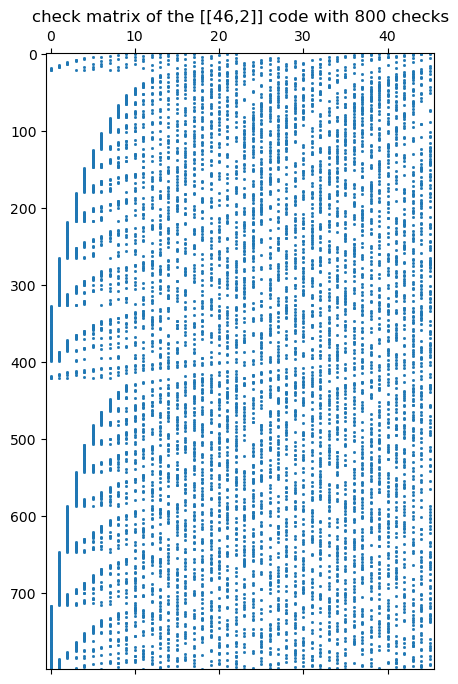

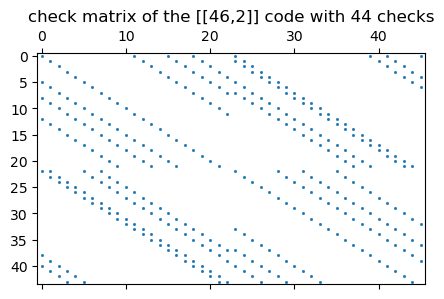

In [19]:
# give parameters for the code and decoder
n = 46
k = 2
m = 800 #number of checks, can also use 46 or 44
m1 = m // 2
m2 = m // 2
n_iterations = 6
codeType = 'GB'

# give parameters for training
#learning rate
lr = 0.001
#training for fixed epsilon_0
ep0 = 0.1
#train on errors of weight ranging from r1 to r2
r1_earlier = 2
r2_earlier = 3
# number of updates
n_batches_earlier = 1500
#number of error patterns in each mini batch
batch_size = 100

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/"
#initialize the decoder, all weights are set to 1
decoder = NBP_oc(n, k, m, m1,m2, codeType, n_iterations, batch_size=batch_size, folder_weights=None)
f = plt.figure(figsize=(5, 8))
plt.spy(decoder.H[0].detach().cpu().numpy(), markersize=1, aspect='auto')
plt.title("check matrix of the [["+str(n)+","+str(k)+"]] code with "+str(m)+" checks")
plt.show()

#for comparision, also plot the original check matrix
decoder_2 = NBP_oc(n, k, n-k, m1,m2, codeType, n_iterations, batch_size=batch_size, folder_weights=None)
f = plt.figure(figsize=(5, 3))
plt.spy(decoder_2.H[0].detach().cpu().numpy(), markersize=1, aspect='auto')
plt.title("check matrix of the [["+str(n)+","+str(k)+"]] code with "+str(n-k)+" checks")
plt.show()

In [20]:
#trainable parameters
parameters = decoder.weights_llr + decoder.weights_cn
#use Adam
optimizer = torch.optim.Adam(parameters, lr=lr)

print('--- Training Metadata ---')
print(f'Code: n={decoder.n}, k={decoder.k}, PCM rows={decoder.m1},{decoder.m2}')
print(f'device: {decoder.device}')
print(f'training ep0 = {ep0}')
print(f'Decoder: {decoder.name}')
print(f'decoding iterations = {decoder.n_iterations}')
print(f'number of batches = {n_batches_earlier}')
print(f'error patterns per batch = {batch_size}')
print(f'learning rate = {lr}\n')

#pre-training stage, basically only the parameters for the first iteration is trained
# 2 箇所 or 3 箇所のエラーでサイズ 100 のミニバッチ * 1500 で学習
loss_pre_train = training_loop(decoder, optimizer, r1_earlier, r2_earlier, ep0, n_batches_earlier, path)
plot_loss(loss_pre_train, path)


#continue to train with higher weight errors, mostly for the later iterations
r1_later = 3
r2_later = 9

n_batches_later = 600
loss = training_loop(decoder, optimizer, r1_later, r2_later, ep0, n_batches_later, path)

plot_loss(torch.cat((loss_pre_train, loss) , dim=0), path)

# loss を pt ファイルで保存
file_loss = "loss.pt"
torch.save(torch.cat((loss_pre_train, loss) , dim=0), os.path.join(path, file_loss))

# params を pt ファイルで保存
params = {
    'n': n,
    'k': k,
    'm': m,
    'm1': m1,
    'm2': m2,
    'n_iterations': n_iterations,
    'codeType': codeType,
    'lr': lr,
    'ep0': ep0,
    'r1_earlier': r1_earlier,
    'r2_earlier': r2_earlier,
    'n_batches_earlier': n_batches_earlier,
    'r1_later': r1_later,
    'r2_later': r2_later,
    'n_batches_later': n_batches_later,
    'batch_size': batch_size
}

file_params = "params.pt"
torch.save(params, os.path.join(path, file_params))

# decoder を pt ファイルで保存
file_decoder = "decoder.pt"
torch.save(decoder, os.path.join(path, file_decoder))

--- Training Metadata ---
Code: n=46, k=2, PCM rows=400,400
device: cuda
training ep0 = 0.1
Decoder: Neural_BP_Decoder
decoding iterations = 6
number of batches = 1500
error patterns per batch = 100
learning rate = 0.001

training on random errors, weight from 2 to 3 


  0%|          | 0/1500 [00:00<?, ?it/s]

tensor([[[3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958],
         [3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958],
         [3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958]],

        [[3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958],
         [3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958],
         [3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958]],

        [[3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958],
         [3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958],
         [3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958]],

        ...,

        [[3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958],
         [3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958],
         [3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958]],

        [[3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958],
         [3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958],
         [3.2958, 3.2958, 3.2958,  ..., 3.2958, 3.2958, 3.2958]],

 

loss 0.2027120292186737:   0%|          | 1/1500 [00:00<08:44,  2.86it/s]

tensor([[[3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991],
         [3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991],
         [3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991]],

        [[3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991],
         [3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991],
         [3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991]],

        [[3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991],
         [3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991],
         [3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991]],

        ...,

        [[3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991],
         [3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991],
         [3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991]],

        [[3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991],
         [3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991],
         [3.2925, 3.2925, 3.2925,  ..., 3.2925, 3.2991, 3.2991]],

 

loss 0.3424201011657715:   0%|          | 2/1500 [00:00<07:53,  3.16it/s]

tensor([[[3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992],
         [3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992],
         [3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992]],

        [[3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992],
         [3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992],
         [3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992]],

        [[3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992],
         [3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992],
         [3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992]],

        ...,

        [[3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992],
         [3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992],
         [3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992]],

        [[3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992],
         [3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992],
         [3.2906, 3.2919, 3.2947,  ..., 3.2930, 3.2982, 3.2992]],

 

loss 0.17712479829788208:   0%|          | 3/1500 [00:00<07:40,  3.25it/s]

tensor([[[3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994],
         [3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994],
         [3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994]],

        [[3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994],
         [3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994],
         [3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994]],

        [[3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994],
         [3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994],
         [3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994]],

        ...,

        [[3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994],
         [3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994],
         [3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994]],

        [[3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994],
         [3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994],
         [3.2917, 3.2899, 3.2964,  ..., 3.2941, 3.2998, 3.2994]],

 

loss 0.19646790623664856:   0%|          | 4/1500 [00:01<07:36,  3.28it/s]

tensor([[[3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998],
         [3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998],
         [3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998]],

        [[3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998],
         [3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998],
         [3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998]],

        [[3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998],
         [3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998],
         [3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998]],

        ...,

        [[3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998],
         [3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998],
         [3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998]],

        [[3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998],
         [3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998],
         [3.2937, 3.2887, 3.2977,  ..., 3.2960, 3.2986, 3.2998]],

 

loss 0.325778990983963:   0%|          | 5/1500 [00:01<08:08,  3.06it/s]  

tensor([[[3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007],
         [3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007],
         [3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007]],

        [[3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007],
         [3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007],
         [3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007]],

        [[3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007],
         [3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007],
         [3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007]],

        ...,

        [[3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007],
         [3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007],
         [3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007]],

        [[3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007],
         [3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007],
         [3.2961, 3.2881, 3.2990,  ..., 3.2977, 3.2983, 3.3007]],

 

loss 0.19066421687602997:   0%|          | 6/1500 [00:01<07:52,  3.16it/s]

tensor([[[3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015],
         [3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015],
         [3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015]],

        [[3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015],
         [3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015],
         [3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015]],

        [[3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015],
         [3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015],
         [3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015]],

        ...,

        [[3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015],
         [3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015],
         [3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015]],

        [[3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015],
         [3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015],
         [3.2987, 3.2873, 3.3006,  ..., 3.2994, 3.2976, 3.3015]],

 

loss 0.3387373387813568:   0%|          | 7/1500 [00:02<07:41,  3.24it/s] 

tensor([[[3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007],
         [3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007],
         [3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007]],

        [[3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007],
         [3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007],
         [3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007]],

        [[3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007],
         [3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007],
         [3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007]],

        ...,

        [[3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007],
         [3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007],
         [3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007]],

        [[3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007],
         [3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007],
         [3.3014, 3.2870, 3.3027,  ..., 3.3005, 3.2967, 3.3007]],

 

loss 0.14462190866470337:   1%|          | 8/1500 [00:02<07:34,  3.28it/s]

tensor([[[3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000],
         [3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000],
         [3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000]],

        [[3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000],
         [3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000],
         [3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000]],

        [[3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000],
         [3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000],
         [3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000]],

        ...,

        [[3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000],
         [3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000],
         [3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000]],

        [[3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000],
         [3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000],
         [3.3028, 3.2872, 3.3041,  ..., 3.3003, 3.2964, 3.3000]],

 

loss 0.21929004788398743:   1%|          | 9/1500 [00:02<07:31,  3.30it/s]

tensor([[[3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000],
         [3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000],
         [3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000]],

        [[3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000],
         [3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000],
         [3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000]],

        [[3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000],
         [3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000],
         [3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000]],

        ...,

        [[3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000],
         [3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000],
         [3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000]],

        [[3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000],
         [3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000],
         [3.3039, 3.2876, 3.3039,  ..., 3.2993, 3.2966, 3.3000]],

 

loss 0.21227069199085236:   1%|          | 10/1500 [00:03<07:28,  3.32it/s]

tensor([[[3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006],
         [3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006],
         [3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006]],

        [[3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006],
         [3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006],
         [3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006]],

        [[3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006],
         [3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006],
         [3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006]],

        ...,

        [[3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006],
         [3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006],
         [3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006]],

        [[3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006],
         [3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006],
         [3.3050, 3.2878, 3.3036,  ..., 3.2982, 3.2970, 3.3006]],

 

loss 0.2907773554325104:   1%|          | 11/1500 [00:03<07:25,  3.34it/s] 

tensor([[[3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010],
         [3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010],
         [3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010]],

        [[3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010],
         [3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010],
         [3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010]],

        [[3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010],
         [3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010],
         [3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010]],

        ...,

        [[3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010],
         [3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010],
         [3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010]],

        [[3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010],
         [3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010],
         [3.3063, 3.2880, 3.3034,  ..., 3.2979, 3.2976, 3.3010]],

 

loss 0.24046777188777924:   1%|          | 12/1500 [00:03<07:23,  3.36it/s]

tensor([[[3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012],
         [3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012],
         [3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012]],

        [[3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012],
         [3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012],
         [3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012]],

        [[3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012],
         [3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012],
         [3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012]],

        ...,

        [[3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012],
         [3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012],
         [3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012]],

        [[3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012],
         [3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012],
         [3.3081, 3.2889, 3.3036,  ..., 3.2975, 3.2983, 3.3012]],

 

loss 0.1496465802192688:   1%|          | 13/1500 [00:04<07:48,  3.17it/s] 

tensor([[[3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016],
         [3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016],
         [3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016]],

        [[3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016],
         [3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016],
         [3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016]],

        [[3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016],
         [3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016],
         [3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016]],

        ...,

        [[3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016],
         [3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016],
         [3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016]],

        [[3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016],
         [3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016],
         [3.3098, 3.2902, 3.3040,  ..., 3.2973, 3.2992, 3.3016]],

 

loss 0.2575007379055023:   1%|          | 14/1500 [00:04<08:01,  3.09it/s]

tensor([[[3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023],
         [3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023],
         [3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023]],

        [[3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023],
         [3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023],
         [3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023]],

        [[3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023],
         [3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023],
         [3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023]],

        ...,

        [[3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023],
         [3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023],
         [3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023]],

        [[3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023],
         [3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023],
         [3.3113, 3.2917, 3.3049,  ..., 3.2965, 3.3005, 3.3023]],

 

loss 0.27786388993263245:   1%|          | 15/1500 [00:04<07:48,  3.17it/s]

tensor([[[3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033],
         [3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033],
         [3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033]],

        [[3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033],
         [3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033],
         [3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033]],

        [[3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033],
         [3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033],
         [3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033]],

        ...,

        [[3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033],
         [3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033],
         [3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033]],

        [[3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033],
         [3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033],
         [3.3132, 3.2934, 3.3059,  ..., 3.2955, 3.3012, 3.3033]],

 

loss 0.23847563564777374:   1%|          | 16/1500 [00:04<07:36,  3.25it/s]

tensor([[[3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041],
         [3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041],
         [3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041]],

        [[3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041],
         [3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041],
         [3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041]],

        [[3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041],
         [3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041],
         [3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041]],

        ...,

        [[3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041],
         [3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041],
         [3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041]],

        [[3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041],
         [3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041],
         [3.3146, 3.2949, 3.3065,  ..., 3.2944, 3.3017, 3.3041]],

 

loss 0.14370912313461304:   1%|          | 17/1500 [00:05<07:29,  3.30it/s]

tensor([[[3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048],
         [3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048],
         [3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048]],

        [[3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048],
         [3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048],
         [3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048]],

        [[3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048],
         [3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048],
         [3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048]],

        ...,

        [[3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048],
         [3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048],
         [3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048]],

        [[3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048],
         [3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048],
         [3.3155, 3.2950, 3.3072,  ..., 3.2936, 3.3021, 3.3048]],

 

loss 0.4354105293750763:   1%|          | 18/1500 [00:05<07:22,  3.35it/s] 

tensor([[[3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057],
         [3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057],
         [3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057]],

        [[3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057],
         [3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057],
         [3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057]],

        [[3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057],
         [3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057],
         [3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057]],

        ...,

        [[3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057],
         [3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057],
         [3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057]],

        [[3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057],
         [3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057],
         [3.3168, 3.2951, 3.3073,  ..., 3.2919, 3.3016, 3.3057]],

 

loss 0.23548129200935364:   1%|▏         | 19/1500 [00:05<07:19,  3.37it/s]

tensor([[[3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053],
         [3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053],
         [3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053]],

        [[3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053],
         [3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053],
         [3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053]],

        [[3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053],
         [3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053],
         [3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053]],

        ...,

        [[3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053],
         [3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053],
         [3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053]],

        [[3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053],
         [3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053],
         [3.3167, 3.2953, 3.3074,  ..., 3.2905, 3.3012, 3.3053]],

 

loss 0.2940423786640167:   1%|▏         | 20/1500 [00:06<07:15,  3.40it/s] 

tensor([[[3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050],
         [3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050],
         [3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050]],

        [[3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050],
         [3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050],
         [3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050]],

        [[3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050],
         [3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050],
         [3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050]],

        ...,

        [[3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050],
         [3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050],
         [3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050]],

        [[3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050],
         [3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050],
         [3.3160, 3.2955, 3.3072,  ..., 3.2886, 3.3014, 3.3050]],

 

loss 0.3564750552177429:   1%|▏         | 21/1500 [00:06<07:11,  3.42it/s]

tensor([[[3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049],
         [3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049],
         [3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049]],

        [[3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049],
         [3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049],
         [3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049]],

        [[3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049],
         [3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049],
         [3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049]],

        ...,

        [[3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049],
         [3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049],
         [3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049]],

        [[3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049],
         [3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049],
         [3.3152, 3.2952, 3.3067,  ..., 3.2866, 3.3010, 3.3049]],

 

loss 0.28487318754196167:   1%|▏         | 22/1500 [00:06<07:09,  3.44it/s]

tensor([[[3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050],
         [3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050],
         [3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050]],

        [[3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050],
         [3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050],
         [3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050]],

        [[3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050],
         [3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050],
         [3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050]],

        ...,

        [[3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050],
         [3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050],
         [3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050]],

        [[3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050],
         [3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050],
         [3.3141, 3.2952, 3.3064,  ..., 3.2847, 3.3003, 3.3050]],

 

loss 0.196260005235672:   2%|▏         | 23/1500 [00:06<07:11,  3.42it/s]  

tensor([[[3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047],
         [3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047],
         [3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047]],

        [[3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047],
         [3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047],
         [3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047]],

        [[3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047],
         [3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047],
         [3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047]],

        ...,

        [[3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047],
         [3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047],
         [3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047]],

        [[3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047],
         [3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047],
         [3.3135, 3.2955, 3.3058,  ..., 3.2833, 3.2995, 3.3047]],

 

loss 0.40555861592292786:   2%|▏         | 24/1500 [00:07<07:10,  3.43it/s]

tensor([[[3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041],
         [3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041],
         [3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041]],

        [[3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041],
         [3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041],
         [3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041]],

        [[3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041],
         [3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041],
         [3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041]],

        ...,

        [[3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041],
         [3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041],
         [3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041]],

        [[3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041],
         [3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041],
         [3.3134, 3.2960, 3.3050,  ..., 3.2820, 3.2992, 3.3041]],

 

loss 0.11815576255321503:   2%|▏         | 25/1500 [00:07<07:08,  3.44it/s]

tensor([[[3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039],
         [3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039],
         [3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039]],

        [[3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039],
         [3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039],
         [3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039]],

        [[3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039],
         [3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039],
         [3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039]],

        ...,

        [[3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039],
         [3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039],
         [3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039]],

        [[3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039],
         [3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039],
         [3.3129, 3.2965, 3.3046,  ..., 3.2811, 3.2990, 3.3039]],

 

loss 0.18829603493213654:   2%|▏         | 26/1500 [00:07<07:07,  3.45it/s]

tensor([[[3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026],
         [3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026],
         [3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026]],

        [[3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026],
         [3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026],
         [3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026]],

        [[3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026],
         [3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026],
         [3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026]],

        ...,

        [[3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026],
         [3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026],
         [3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026]],

        [[3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026],
         [3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026],
         [3.3122, 3.2973, 3.3043,  ..., 3.2802, 3.2981, 3.3026]],

 

loss 0.2632962465286255:   2%|▏         | 27/1500 [00:08<07:06,  3.46it/s] 

tensor([[[3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014],
         [3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014],
         [3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014]],

        [[3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014],
         [3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014],
         [3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014]],

        [[3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014],
         [3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014],
         [3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014]],

        ...,

        [[3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014],
         [3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014],
         [3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014]],

        [[3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014],
         [3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014],
         [3.3115, 3.2988, 3.3039,  ..., 3.2792, 3.2974, 3.3014]],

 

loss 0.18307994306087494:   2%|▏         | 28/1500 [00:08<07:07,  3.44it/s]

tensor([[[3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009],
         [3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009],
         [3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009]],

        [[3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009],
         [3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009],
         [3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009]],

        [[3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009],
         [3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009],
         [3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009]],

        ...,

        [[3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009],
         [3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009],
         [3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009]],

        [[3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009],
         [3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009],
         [3.3111, 3.3000, 3.3032,  ..., 3.2782, 3.2972, 3.3009]],

 

loss 0.2015797346830368:   2%|▏         | 29/1500 [00:08<07:05,  3.46it/s] 

tensor([[[3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002],
         [3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002],
         [3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002]],

        [[3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002],
         [3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002],
         [3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002]],

        [[3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002],
         [3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002],
         [3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002]],

        ...,

        [[3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002],
         [3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002],
         [3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002]],

        [[3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002],
         [3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002],
         [3.3104, 3.3010, 3.3030,  ..., 3.2766, 3.2970, 3.3002]],

 

loss 0.15544451773166656:   2%|▏         | 30/1500 [00:09<07:04,  3.46it/s]

tensor([[[3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997],
         [3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997],
         [3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997]],

        [[3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997],
         [3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997],
         [3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997]],

        [[3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997],
         [3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997],
         [3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997]],

        ...,

        [[3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997],
         [3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997],
         [3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997]],

        [[3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997],
         [3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997],
         [3.3099, 3.3020, 3.3028,  ..., 3.2750, 3.2973, 3.2997]],

 

loss 0.20917227864265442:   2%|▏         | 31/1500 [00:09<07:03,  3.47it/s]

tensor([[[3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990],
         [3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990],
         [3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990]],

        [[3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990],
         [3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990],
         [3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990]],

        [[3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990],
         [3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990],
         [3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990]],

        ...,

        [[3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990],
         [3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990],
         [3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990]],

        [[3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990],
         [3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990],
         [3.3091, 3.3033, 3.3028,  ..., 3.2730, 3.2972, 3.2990]],

 

loss 0.27193334698677063:   2%|▏         | 32/1500 [00:09<07:03,  3.47it/s]

tensor([[[3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989],
         [3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989],
         [3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989]],

        [[3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989],
         [3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989],
         [3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989]],

        [[3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989],
         [3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989],
         [3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989]],

        ...,

        [[3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989],
         [3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989],
         [3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989]],

        [[3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989],
         [3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989],
         [3.3083, 3.3051, 3.3031,  ..., 3.2710, 3.2981, 3.2989]],

 

loss 0.23959051072597504:   2%|▏         | 33/1500 [00:09<07:03,  3.46it/s]

tensor([[[3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988],
         [3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988],
         [3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988]],

        [[3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988],
         [3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988],
         [3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988]],

        [[3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988],
         [3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988],
         [3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988]],

        ...,

        [[3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988],
         [3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988],
         [3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988]],

        [[3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988],
         [3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988],
         [3.3080, 3.3071, 3.3036,  ..., 3.2694, 3.2979, 3.2988]],

 

loss 0.1531350314617157:   2%|▏         | 34/1500 [00:10<07:03,  3.47it/s] 

tensor([[[3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986],
         [3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986],
         [3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986]],

        [[3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986],
         [3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986],
         [3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986]],

        [[3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986],
         [3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986],
         [3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986]],

        ...,

        [[3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986],
         [3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986],
         [3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986]],

        [[3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986],
         [3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986],
         [3.3077, 3.3089, 3.3043,  ..., 3.2681, 3.2978, 3.2986]],

 

loss 0.15573230385780334:   2%|▏         | 35/1500 [00:10<07:02,  3.47it/s]

tensor([[[3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983],
         [3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983],
         [3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983]],

        [[3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983],
         [3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983],
         [3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983]],

        [[3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983],
         [3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983],
         [3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983]],

        ...,

        [[3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983],
         [3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983],
         [3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983]],

        [[3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983],
         [3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983],
         [3.3076, 3.3107, 3.3049,  ..., 3.2668, 3.2975, 3.2983]],

 

loss 0.1966056227684021:   2%|▏         | 36/1500 [00:10<07:01,  3.47it/s] 

tensor([[[3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977],
         [3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977],
         [3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977]],

        [[3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977],
         [3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977],
         [3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977]],

        [[3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977],
         [3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977],
         [3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977]],

        ...,

        [[3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977],
         [3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977],
         [3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977]],

        [[3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977],
         [3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977],
         [3.3072, 3.3121, 3.3057,  ..., 3.2652, 3.2975, 3.2977]],

 

loss 0.23184330761432648:   2%|▏         | 37/1500 [00:11<07:01,  3.47it/s]

tensor([[[3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974],
         [3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974],
         [3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974]],

        [[3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974],
         [3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974],
         [3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974]],

        [[3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974],
         [3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974],
         [3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974]],

        ...,

        [[3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974],
         [3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974],
         [3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974]],

        [[3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974],
         [3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974],
         [3.3068, 3.3134, 3.3062,  ..., 3.2638, 3.2976, 3.2974]],

 

loss 0.2088630050420761:   3%|▎         | 38/1500 [00:11<07:01,  3.47it/s] 

tensor([[[3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972],
         [3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972],
         [3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972]],

        [[3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972],
         [3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972],
         [3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972]],

        [[3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972],
         [3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972],
         [3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972]],

        ...,

        [[3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972],
         [3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972],
         [3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972]],

        [[3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972],
         [3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972],
         [3.3071, 3.3145, 3.3064,  ..., 3.2622, 3.2977, 3.2972]],

 

loss 0.2618894875049591:   3%|▎         | 39/1500 [00:11<07:00,  3.47it/s]

tensor([[[3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969],
         [3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969],
         [3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969]],

        [[3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969],
         [3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969],
         [3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969]],

        [[3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969],
         [3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969],
         [3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969]],

        ...,

        [[3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969],
         [3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969],
         [3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969]],

        [[3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969],
         [3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969],
         [3.3073, 3.3157, 3.3064,  ..., 3.2606, 3.2980, 3.2969]],

 

loss 0.38997194170951843:   3%|▎         | 40/1500 [00:11<07:01,  3.46it/s]

tensor([[[3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967],
         [3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967],
         [3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967]],

        [[3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967],
         [3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967],
         [3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967]],

        [[3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967],
         [3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967],
         [3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967]],

        ...,

        [[3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967],
         [3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967],
         [3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967]],

        [[3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967],
         [3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967],
         [3.3077, 3.3165, 3.3061,  ..., 3.2590, 3.2981, 3.2967]],

 

loss 0.23784209787845612:   3%|▎         | 41/1500 [00:12<07:01,  3.46it/s]

tensor([[[3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966],
         [3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966],
         [3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966]],

        [[3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966],
         [3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966],
         [3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966]],

        [[3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966],
         [3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966],
         [3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966]],

        ...,

        [[3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966],
         [3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966],
         [3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966]],

        [[3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966],
         [3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966],
         [3.3081, 3.3171, 3.3053,  ..., 3.2575, 3.2980, 3.2966]],

 

loss 0.11693751811981201:   3%|▎         | 42/1500 [00:12<07:03,  3.44it/s]

tensor([[[3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966],
         [3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966],
         [3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966]],

        [[3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966],
         [3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966],
         [3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966]],

        [[3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966],
         [3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966],
         [3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966]],

        ...,

        [[3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966],
         [3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966],
         [3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966]],

        [[3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966],
         [3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966],
         [3.3088, 3.3178, 3.3047,  ..., 3.2561, 3.2978, 3.2966]],

 

loss 0.31980204582214355:   3%|▎         | 43/1500 [00:12<07:06,  3.42it/s]

tensor([[[3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964],
         [3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964],
         [3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964]],

        [[3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964],
         [3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964],
         [3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964]],

        [[3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964],
         [3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964],
         [3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964]],

        ...,

        [[3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964],
         [3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964],
         [3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964]],

        [[3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964],
         [3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964],
         [3.3091, 3.3185, 3.3033,  ..., 3.2547, 3.2979, 3.2964]],

 

loss 0.18826834857463837:   3%|▎         | 44/1500 [00:13<07:30,  3.23it/s]

tensor([[[3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965],
         [3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965],
         [3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965]],

        [[3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965],
         [3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965],
         [3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965]],

        [[3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965],
         [3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965],
         [3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965]],

        ...,

        [[3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965],
         [3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965],
         [3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965]],

        [[3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965],
         [3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965],
         [3.3092, 3.3189, 3.3023,  ..., 3.2533, 3.2982, 3.2965]],

 

loss 0.20701245963573456:   3%|▎         | 45/1500 [00:13<07:48,  3.11it/s]

tensor([[[3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963],
         [3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963],
         [3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963]],

        [[3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963],
         [3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963],
         [3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963]],

        [[3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963],
         [3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963],
         [3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963]],

        ...,

        [[3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963],
         [3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963],
         [3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963]],

        [[3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963],
         [3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963],
         [3.3093, 3.3190, 3.3011,  ..., 3.2521, 3.2984, 3.2963]],

 

loss 0.10450467467308044:   3%|▎         | 46/1500 [00:13<07:58,  3.04it/s]

tensor([[[3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963],
         [3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963],
         [3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963]],

        [[3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963],
         [3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963],
         [3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963]],

        [[3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963],
         [3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963],
         [3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963]],

        ...,

        [[3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963],
         [3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963],
         [3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963]],

        [[3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963],
         [3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963],
         [3.3094, 3.3195, 3.2997,  ..., 3.2510, 3.2987, 3.2963]],

 

loss 0.3217363953590393:   3%|▎         | 47/1500 [00:14<08:07,  2.98it/s] 

tensor([[[3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958],
         [3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958],
         [3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958]],

        [[3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958],
         [3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958],
         [3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958]],

        [[3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958],
         [3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958],
         [3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958]],

        ...,

        [[3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958],
         [3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958],
         [3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958]],

        [[3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958],
         [3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958],
         [3.3098, 3.3196, 3.2977,  ..., 3.2499, 3.2991, 3.2958]],

 

loss 0.22517463564872742:   3%|▎         | 48/1500 [00:14<08:18,  2.91it/s]

tensor([[[3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952],
         [3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952],
         [3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952]],

        [[3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952],
         [3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952],
         [3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952]],

        [[3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952],
         [3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952],
         [3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952]],

        ...,

        [[3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952],
         [3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952],
         [3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952]],

        [[3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952],
         [3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952],
         [3.3097, 3.3199, 3.2959,  ..., 3.2484, 3.2992, 3.2952]],

 

loss 0.2640072703361511:   3%|▎         | 49/1500 [00:14<08:23,  2.88it/s] 

tensor([[[3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944],
         [3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944],
         [3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944]],

        [[3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944],
         [3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944],
         [3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944]],

        [[3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944],
         [3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944],
         [3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944]],

        ...,

        [[3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944],
         [3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944],
         [3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944]],

        [[3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944],
         [3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944],
         [3.3092, 3.3201, 3.2943,  ..., 3.2470, 3.2993, 3.2944]],

 

loss 0.22650863230228424:   3%|▎         | 50/1500 [00:15<08:22,  2.89it/s]

tensor([[[3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939],
         [3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939],
         [3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939]],

        [[3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939],
         [3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939],
         [3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939]],

        [[3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939],
         [3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939],
         [3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939]],

        ...,

        [[3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939],
         [3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939],
         [3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939]],

        [[3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939],
         [3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939],
         [3.3081, 3.3209, 3.2923,  ..., 3.2455, 3.2998, 3.2939]],

 

loss 0.12395447492599487:   3%|▎         | 51/1500 [00:15<07:57,  3.03it/s]

tensor([[[3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932],
         [3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932],
         [3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932]],

        [[3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932],
         [3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932],
         [3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932]],

        [[3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932],
         [3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932],
         [3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932]],

        ...,

        [[3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932],
         [3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932],
         [3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932]],

        [[3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932],
         [3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932],
         [3.3073, 3.3213, 3.2904,  ..., 3.2442, 3.3005, 3.2932]],

 

loss 0.31903278827667236:   3%|▎         | 52/1500 [00:15<07:41,  3.14it/s]

tensor([[[3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931],
         [3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931],
         [3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931]],

        [[3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931],
         [3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931],
         [3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931]],

        [[3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931],
         [3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931],
         [3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931]],

        ...,

        [[3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931],
         [3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931],
         [3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931]],

        [[3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931],
         [3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931],
         [3.3060, 3.3217, 3.2885,  ..., 3.2427, 3.3007, 3.2931]],

 

loss 0.22316034138202667:   4%|▎         | 53/1500 [00:16<07:29,  3.22it/s]

tensor([[[3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924],
         [3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924],
         [3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924]],

        [[3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924],
         [3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924],
         [3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924]],

        [[3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924],
         [3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924],
         [3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924]],

        ...,

        [[3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924],
         [3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924],
         [3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924]],

        [[3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924],
         [3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924],
         [3.3045, 3.3219, 3.2867,  ..., 3.2413, 3.3005, 3.2924]],

 

loss 0.3545551598072052:   4%|▎         | 54/1500 [00:16<07:23,  3.26it/s] 

tensor([[[3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925],
         [3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925],
         [3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925]],

        [[3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925],
         [3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925],
         [3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925]],

        [[3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925],
         [3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925],
         [3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925]],

        ...,

        [[3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925],
         [3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925],
         [3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925]],

        [[3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925],
         [3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925],
         [3.3036, 3.3223, 3.2846,  ..., 3.2400, 3.2996, 3.2925]],

 

loss 0.20455819368362427:   4%|▎         | 55/1500 [00:16<07:16,  3.31it/s]

tensor([[[3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921],
         [3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921],
         [3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921]],

        [[3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921],
         [3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921],
         [3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921]],

        [[3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921],
         [3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921],
         [3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921]],

        ...,

        [[3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921],
         [3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921],
         [3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921]],

        [[3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921],
         [3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921],
         [3.3026, 3.3224, 3.2833,  ..., 3.2390, 3.2980, 3.2921]],

 

loss 0.32158583402633667:   4%|▎         | 56/1500 [00:16<07:11,  3.35it/s]

tensor([[[3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914],
         [3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914],
         [3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914]],

        [[3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914],
         [3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914],
         [3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914]],

        [[3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914],
         [3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914],
         [3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914]],

        ...,

        [[3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914],
         [3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914],
         [3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914]],

        [[3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914],
         [3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914],
         [3.3007, 3.3227, 3.2821,  ..., 3.2381, 3.2963, 3.2914]],

 

loss 0.22567462921142578:   4%|▍         | 57/1500 [00:17<07:08,  3.37it/s]

tensor([[[3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906],
         [3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906],
         [3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906]],

        [[3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906],
         [3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906],
         [3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906]],

        [[3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906],
         [3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906],
         [3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906]],

        ...,

        [[3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906],
         [3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906],
         [3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906]],

        [[3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906],
         [3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906],
         [3.2997, 3.3225, 3.2809,  ..., 3.2373, 3.2942, 3.2906]],

 

loss 0.22360733151435852:   4%|▍         | 58/1500 [00:17<07:03,  3.40it/s]

tensor([[[3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899],
         [3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899],
         [3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899]],

        [[3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899],
         [3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899],
         [3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899]],

        [[3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899],
         [3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899],
         [3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899]],

        ...,

        [[3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899],
         [3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899],
         [3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899]],

        [[3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899],
         [3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899],
         [3.2988, 3.3225, 3.2799,  ..., 3.2365, 3.2922, 3.2899]],

 

loss 0.21399742364883423:   4%|▍         | 59/1500 [00:17<07:01,  3.42it/s]

tensor([[[3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897],
         [3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897],
         [3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897]],

        [[3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897],
         [3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897],
         [3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897]],

        [[3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897],
         [3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897],
         [3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897]],

        ...,

        [[3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897],
         [3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897],
         [3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897]],

        [[3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897],
         [3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897],
         [3.2978, 3.3223, 3.2788,  ..., 3.2354, 3.2904, 3.2897]],

 

loss 0.3250846266746521:   4%|▍         | 60/1500 [00:18<07:02,  3.41it/s] 

tensor([[[3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893],
         [3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893],
         [3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893]],

        [[3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893],
         [3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893],
         [3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893]],

        [[3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893],
         [3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893],
         [3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893]],

        ...,

        [[3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893],
         [3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893],
         [3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893]],

        [[3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893],
         [3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893],
         [3.2973, 3.3222, 3.2775,  ..., 3.2340, 3.2890, 3.2893]],

 

loss 0.17259857058525085:   4%|▍         | 61/1500 [00:18<07:01,  3.41it/s]

tensor([[[3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891],
         [3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891],
         [3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891]],

        [[3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891],
         [3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891],
         [3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891]],

        [[3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891],
         [3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891],
         [3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891]],

        ...,

        [[3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891],
         [3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891],
         [3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891]],

        [[3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891],
         [3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891],
         [3.2969, 3.3222, 3.2762,  ..., 3.2328, 3.2877, 3.2891]],

 

loss 0.26487264037132263:   4%|▍         | 62/1500 [00:18<07:09,  3.35it/s]

tensor([[[3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885],
         [3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885],
         [3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885]],

        [[3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885],
         [3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885],
         [3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885]],

        [[3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885],
         [3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885],
         [3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885]],

        ...,

        [[3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885],
         [3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885],
         [3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885]],

        [[3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885],
         [3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885],
         [3.2965, 3.3218, 3.2750,  ..., 3.2319, 3.2869, 3.2885]],

 

loss 0.22891882061958313:   4%|▍         | 63/1500 [00:19<07:08,  3.36it/s]

tensor([[[3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881],
         [3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881],
         [3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881]],

        [[3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881],
         [3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881],
         [3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881]],

        [[3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881],
         [3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881],
         [3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881]],

        ...,

        [[3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881],
         [3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881],
         [3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881]],

        [[3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881],
         [3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881],
         [3.2957, 3.3213, 3.2743,  ..., 3.2311, 3.2863, 3.2881]],

 

loss 0.2967242896556854:   4%|▍         | 64/1500 [00:19<07:08,  3.35it/s] 

tensor([[[3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878],
         [3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878],
         [3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878]],

        [[3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878],
         [3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878],
         [3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878]],

        [[3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878],
         [3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878],
         [3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878]],

        ...,

        [[3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878],
         [3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878],
         [3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878]],

        [[3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878],
         [3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878],
         [3.2949, 3.3210, 3.2736,  ..., 3.2301, 3.2851, 3.2878]],

 

loss 0.34270837903022766:   4%|▍         | 65/1500 [00:19<07:04,  3.38it/s]

tensor([[[3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869],
         [3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869],
         [3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869]],

        [[3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869],
         [3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869],
         [3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869]],

        [[3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869],
         [3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869],
         [3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869]],

        ...,

        [[3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869],
         [3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869],
         [3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869]],

        [[3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869],
         [3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869],
         [3.2935, 3.3203, 3.2724,  ..., 3.2291, 3.2842, 3.2869]],

 

loss 0.13058261573314667:   4%|▍         | 66/1500 [00:19<07:04,  3.38it/s]

tensor([[[3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860],
         [3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860],
         [3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860]],

        [[3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860],
         [3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860],
         [3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860]],

        [[3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860],
         [3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860],
         [3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860]],

        ...,

        [[3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860],
         [3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860],
         [3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860]],

        [[3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860],
         [3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860],
         [3.2924, 3.3190, 3.2714,  ..., 3.2283, 3.2833, 3.2860]],

 

loss 0.10733622312545776:   4%|▍         | 67/1500 [00:20<07:04,  3.37it/s]

tensor([[[3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853],
         [3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853],
         [3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853]],

        [[3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853],
         [3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853],
         [3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853]],

        [[3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853],
         [3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853],
         [3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853]],

        ...,

        [[3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853],
         [3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853],
         [3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853]],

        [[3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853],
         [3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853],
         [3.2915, 3.3181, 3.2709,  ..., 3.2278, 3.2827, 3.2853]],

 

loss 0.2763560116291046:   5%|▍         | 68/1500 [00:20<07:00,  3.41it/s] 

tensor([[[3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846],
         [3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846],
         [3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846]],

        [[3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846],
         [3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846],
         [3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846]],

        [[3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846],
         [3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846],
         [3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846]],

        ...,

        [[3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846],
         [3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846],
         [3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846]],

        [[3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846],
         [3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846],
         [3.2905, 3.3177, 3.2699,  ..., 3.2268, 3.2815, 3.2846]],

 

loss 0.280636191368103:   5%|▍         | 69/1500 [00:20<07:01,  3.39it/s] 

tensor([[[3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841],
         [3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841],
         [3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841]],

        [[3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841],
         [3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841],
         [3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841]],

        [[3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841],
         [3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841],
         [3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841]],

        ...,

        [[3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841],
         [3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841],
         [3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841]],

        [[3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841],
         [3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841],
         [3.2898, 3.3173, 3.2691,  ..., 3.2262, 3.2803, 3.2841]],

 

loss 0.31967857480049133:   5%|▍         | 70/1500 [00:21<06:58,  3.42it/s]

tensor([[[3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838],
         [3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838],
         [3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838]],

        [[3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838],
         [3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838],
         [3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838]],

        [[3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838],
         [3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838],
         [3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838]],

        ...,

        [[3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838],
         [3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838],
         [3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838]],

        [[3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838],
         [3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838],
         [3.2893, 3.3165, 3.2685,  ..., 3.2262, 3.2797, 3.2838]],

 

loss 0.28065910935401917:   5%|▍         | 71/1500 [00:21<06:59,  3.41it/s]

tensor([[[3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834],
         [3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834],
         [3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834]],

        [[3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834],
         [3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834],
         [3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834]],

        [[3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834],
         [3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834],
         [3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834]],

        ...,

        [[3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834],
         [3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834],
         [3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834]],

        [[3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834],
         [3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834],
         [3.2890, 3.3162, 3.2682,  ..., 3.2261, 3.2796, 3.2834]],

 

loss 0.13627508282661438:   5%|▍         | 72/1500 [00:21<07:00,  3.39it/s]

tensor([[[3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828],
         [3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828],
         [3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828]],

        [[3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828],
         [3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828],
         [3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828]],

        [[3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828],
         [3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828],
         [3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828]],

        ...,

        [[3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828],
         [3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828],
         [3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828]],

        [[3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828],
         [3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828],
         [3.2889, 3.3159, 3.2680,  ..., 3.2261, 3.2794, 3.2828]],

 

loss 0.420175164937973:   5%|▍         | 73/1500 [00:22<06:59,  3.40it/s]  

tensor([[[3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824],
         [3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824],
         [3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824]],

        [[3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824],
         [3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824],
         [3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824]],

        [[3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824],
         [3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824],
         [3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824]],

        ...,

        [[3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824],
         [3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824],
         [3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824]],

        [[3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824],
         [3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824],
         [3.2889, 3.3153, 3.2674,  ..., 3.2260, 3.2787, 3.2824]],

 

loss 0.3454352021217346:   5%|▍         | 74/1500 [00:22<06:57,  3.42it/s]

tensor([[[3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815],
         [3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815],
         [3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815]],

        [[3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815],
         [3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815],
         [3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815]],

        [[3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815],
         [3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815],
         [3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815]],

        ...,

        [[3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815],
         [3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815],
         [3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815]],

        [[3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815],
         [3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815],
         [3.2887, 3.3150, 3.2666,  ..., 3.2260, 3.2783, 3.2815]],

 

loss 0.41520631313323975:   5%|▌         | 75/1500 [00:22<07:03,  3.36it/s]

tensor([[[3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803],
         [3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803],
         [3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803]],

        [[3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803],
         [3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803],
         [3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803]],

        [[3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803],
         [3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803],
         [3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803]],

        ...,

        [[3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803],
         [3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803],
         [3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803]],

        [[3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803],
         [3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803],
         [3.2884, 3.3147, 3.2663,  ..., 3.2263, 3.2778, 3.2803]],

 

loss 0.17616015672683716:   5%|▌         | 76/1500 [00:22<07:00,  3.39it/s]

tensor([[[3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796],
         [3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796],
         [3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796]],

        [[3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796],
         [3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796],
         [3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796]],

        [[3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796],
         [3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796],
         [3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796]],

        ...,

        [[3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796],
         [3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796],
         [3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796]],

        [[3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796],
         [3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796],
         [3.2880, 3.3148, 3.2660,  ..., 3.2266, 3.2774, 3.2796]],

 

loss 0.12028276175260544:   5%|▌         | 77/1500 [00:23<07:31,  3.15it/s]

tensor([[[3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788],
         [3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788],
         [3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788]],

        [[3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788],
         [3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788],
         [3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788]],

        [[3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788],
         [3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788],
         [3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788]],

        ...,

        [[3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788],
         [3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788],
         [3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788]],

        [[3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788],
         [3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788],
         [3.2880, 3.3150, 3.2655,  ..., 3.2267, 3.2770, 3.2788]],

 

loss 0.2706778645515442:   5%|▌         | 78/1500 [00:23<07:45,  3.05it/s] 

tensor([[[3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774],
         [3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774],
         [3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774]],

        [[3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774],
         [3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774],
         [3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774]],

        [[3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774],
         [3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774],
         [3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774]],

        ...,

        [[3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774],
         [3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774],
         [3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774]],

        [[3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774],
         [3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774],
         [3.2877, 3.3152, 3.2654,  ..., 3.2271, 3.2763, 3.2774]],

 

loss 0.20311710238456726:   5%|▌         | 79/1500 [00:23<07:28,  3.17it/s]

tensor([[[3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761],
         [3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761],
         [3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761]],

        [[3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761],
         [3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761],
         [3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761]],

        [[3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761],
         [3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761],
         [3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761]],

        ...,

        [[3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761],
         [3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761],
         [3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761]],

        [[3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761],
         [3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761],
         [3.2876, 3.3147, 3.2651,  ..., 3.2275, 3.2754, 3.2761]],

 

loss 0.1691466122865677:   5%|▌         | 80/1500 [00:24<07:21,  3.21it/s] 

tensor([[[3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742],
         [3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742],
         [3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742]],

        [[3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742],
         [3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742],
         [3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742]],

        [[3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742],
         [3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742],
         [3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742]],

        ...,

        [[3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742],
         [3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742],
         [3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742]],

        [[3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742],
         [3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742],
         [3.2873, 3.3148, 3.2649,  ..., 3.2279, 3.2745, 3.2742]],

 

loss 0.29468172788619995:   5%|▌         | 81/1500 [00:24<07:12,  3.28it/s]

tensor([[[3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722],
         [3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722],
         [3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722]],

        [[3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722],
         [3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722],
         [3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722]],

        [[3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722],
         [3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722],
         [3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722]],

        ...,

        [[3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722],
         [3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722],
         [3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722]],

        [[3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722],
         [3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722],
         [3.2875, 3.3143, 3.2646,  ..., 3.2284, 3.2729, 3.2722]],

 

loss 0.17139467597007751:   5%|▌         | 82/1500 [00:24<07:13,  3.27it/s]

tensor([[[3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705],
         [3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705],
         [3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705]],

        [[3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705],
         [3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705],
         [3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705]],

        [[3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705],
         [3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705],
         [3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705]],

        ...,

        [[3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705],
         [3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705],
         [3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705]],

        [[3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705],
         [3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705],
         [3.2879, 3.3138, 3.2646,  ..., 3.2288, 3.2710, 3.2705]],

 

loss 0.15942661464214325:   6%|▌         | 83/1500 [00:25<07:09,  3.30it/s]

tensor([[[3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691],
         [3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691],
         [3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691]],

        [[3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691],
         [3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691],
         [3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691]],

        [[3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691],
         [3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691],
         [3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691]],

        ...,

        [[3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691],
         [3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691],
         [3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691]],

        [[3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691],
         [3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691],
         [3.2883, 3.3135, 3.2645,  ..., 3.2290, 3.2691, 3.2691]],

 

loss 0.1114434003829956:   6%|▌         | 84/1500 [00:25<07:04,  3.34it/s] 

tensor([[[3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679],
         [3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679],
         [3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679]],

        [[3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679],
         [3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679],
         [3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679]],

        [[3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679],
         [3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679],
         [3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679]],

        ...,

        [[3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679],
         [3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679],
         [3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679]],

        [[3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679],
         [3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679],
         [3.2889, 3.3133, 3.2645,  ..., 3.2291, 3.2676, 3.2679]],

 

loss 0.24600806832313538:   6%|▌         | 85/1500 [00:25<07:13,  3.27it/s]

tensor([[[3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673],
         [3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673],
         [3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673]],

        [[3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673],
         [3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673],
         [3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673]],

        [[3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673],
         [3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673],
         [3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673]],

        ...,

        [[3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673],
         [3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673],
         [3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673]],

        [[3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673],
         [3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673],
         [3.2897, 3.3129, 3.2645,  ..., 3.2291, 3.2662, 3.2673]],

 

loss 0.2255491018295288:   6%|▌         | 86/1500 [00:25<07:06,  3.32it/s] 

tensor([[[3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669],
         [3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669],
         [3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669]],

        [[3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669],
         [3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669],
         [3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669]],

        [[3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669],
         [3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669],
         [3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669]],

        ...,

        [[3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669],
         [3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669],
         [3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669]],

        [[3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669],
         [3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669],
         [3.2906, 3.3125, 3.2639,  ..., 3.2288, 3.2653, 3.2669]],

 

loss 0.2178632616996765:   6%|▌         | 87/1500 [00:26<07:09,  3.29it/s]

tensor([[[3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666],
         [3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666],
         [3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666]],

        [[3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666],
         [3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666],
         [3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666]],

        [[3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666],
         [3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666],
         [3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666]],

        ...,

        [[3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666],
         [3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666],
         [3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666]],

        [[3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666],
         [3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666],
         [3.2917, 3.3125, 3.2635,  ..., 3.2284, 3.2645, 3.2666]],

 

loss 0.2984312176704407:   6%|▌         | 88/1500 [00:26<07:03,  3.33it/s]

tensor([[[3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664],
         [3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664],
         [3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664]],

        [[3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664],
         [3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664],
         [3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664]],

        [[3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664],
         [3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664],
         [3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664]],

        ...,

        [[3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664],
         [3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664],
         [3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664]],

        [[3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664],
         [3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664],
         [3.2937, 3.3118, 3.2624,  ..., 3.2284, 3.2639, 3.2664]],

 

loss 0.19892361760139465:   6%|▌         | 89/1500 [00:26<06:58,  3.37it/s]

tensor([[[3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653],
         [3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653],
         [3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653]],

        [[3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653],
         [3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653],
         [3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653]],

        [[3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653],
         [3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653],
         [3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653]],

        ...,

        [[3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653],
         [3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653],
         [3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653]],

        [[3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653],
         [3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653],
         [3.2955, 3.3112, 3.2615,  ..., 3.2285, 3.2632, 3.2653]],

 

loss 0.2832298278808594:   6%|▌         | 90/1500 [00:27<07:07,  3.30it/s] 

tensor([[[3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639],
         [3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639],
         [3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639]],

        [[3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639],
         [3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639],
         [3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639]],

        [[3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639],
         [3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639],
         [3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639]],

        ...,

        [[3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639],
         [3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639],
         [3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639]],

        [[3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639],
         [3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639],
         [3.2968, 3.3101, 3.2607,  ..., 3.2284, 3.2624, 3.2639]],

 

loss 0.3658432066440582:   6%|▌         | 91/1500 [00:27<07:02,  3.34it/s]

tensor([[[3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628],
         [3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628],
         [3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628]],

        [[3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628],
         [3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628],
         [3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628]],

        [[3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628],
         [3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628],
         [3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628]],

        ...,

        [[3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628],
         [3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628],
         [3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628]],

        [[3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628],
         [3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628],
         [3.2982, 3.3085, 3.2600,  ..., 3.2271, 3.2618, 3.2628]],

 

loss 0.14942730963230133:   6%|▌         | 92/1500 [00:27<07:09,  3.28it/s]

tensor([[[3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613],
         [3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613],
         [3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613]],

        [[3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613],
         [3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613],
         [3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613]],

        [[3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613],
         [3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613],
         [3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613]],

        ...,

        [[3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613],
         [3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613],
         [3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613]],

        [[3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613],
         [3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613],
         [3.2992, 3.3072, 3.2595,  ..., 3.2260, 3.2606, 3.2613]],

 

loss 0.21191631257534027:   6%|▌         | 93/1500 [00:28<07:06,  3.30it/s]

tensor([[[3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600],
         [3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600],
         [3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600]],

        [[3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600],
         [3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600],
         [3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600]],

        [[3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600],
         [3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600],
         [3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600]],

        ...,

        [[3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600],
         [3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600],
         [3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600]],

        [[3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600],
         [3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600],
         [3.3005, 3.3057, 3.2592,  ..., 3.2254, 3.2595, 3.2600]],

 

loss 0.3318578004837036:   6%|▋         | 94/1500 [00:28<07:42,  3.04it/s] 

tensor([[[3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587],
         [3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587],
         [3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587]],

        [[3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587],
         [3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587],
         [3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587]],

        [[3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587],
         [3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587],
         [3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587]],

        ...,

        [[3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587],
         [3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587],
         [3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587]],

        [[3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587],
         [3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587],
         [3.3015, 3.3047, 3.2592,  ..., 3.2250, 3.2584, 3.2587]],

 

loss 0.1135367825627327:   6%|▋         | 95/1500 [00:28<07:47,  3.00it/s]

tensor([[[3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574],
         [3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574],
         [3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574]],

        [[3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574],
         [3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574],
         [3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574]],

        [[3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574],
         [3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574],
         [3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574]],

        ...,

        [[3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574],
         [3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574],
         [3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574]],

        [[3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574],
         [3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574],
         [3.3021, 3.3039, 3.2594,  ..., 3.2247, 3.2576, 3.2574]],

 

loss 0.11447947472333908:   6%|▋         | 96/1500 [00:29<07:52,  2.97it/s]

tensor([[[3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563],
         [3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563],
         [3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563]],

        [[3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563],
         [3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563],
         [3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563]],

        [[3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563],
         [3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563],
         [3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563]],

        ...,

        [[3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563],
         [3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563],
         [3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563]],

        [[3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563],
         [3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563],
         [3.3024, 3.3031, 3.2597,  ..., 3.2245, 3.2569, 3.2563]],

 

loss 0.2364095002412796:   6%|▋         | 97/1500 [00:29<07:52,  2.97it/s] 

tensor([[[3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555],
         [3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555],
         [3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555]],

        [[3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555],
         [3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555],
         [3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555]],

        [[3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555],
         [3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555],
         [3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555]],

        ...,

        [[3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555],
         [3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555],
         [3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555]],

        [[3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555],
         [3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555],
         [3.3026, 3.3018, 3.2594,  ..., 3.2243, 3.2563, 3.2555]],

 

loss 0.21509726345539093:   7%|▋         | 98/1500 [00:29<07:56,  2.94it/s]

tensor([[[3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544],
         [3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544],
         [3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544]],

        [[3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544],
         [3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544],
         [3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544]],

        [[3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544],
         [3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544],
         [3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544]],

        ...,

        [[3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544],
         [3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544],
         [3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544]],

        [[3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544],
         [3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544],
         [3.3031, 3.3011, 3.2592,  ..., 3.2237, 3.2563, 3.2544]],

 

loss 0.14799430966377258:   7%|▋         | 99/1500 [00:30<07:55,  2.95it/s]

tensor([[[3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536],
         [3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536],
         [3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536]],

        [[3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536],
         [3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536],
         [3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536]],

        [[3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536],
         [3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536],
         [3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536]],

        ...,

        [[3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536],
         [3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536],
         [3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536]],

        [[3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536],
         [3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536],
         [3.3031, 3.3005, 3.2592,  ..., 3.2233, 3.2558, 3.2536]],

 

loss 0.12665759027004242:   7%|▋         | 100/1500 [00:30<07:58,  2.93it/s]

tensor([[[3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528],
         [3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528],
         [3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528]],

        [[3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528],
         [3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528],
         [3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528]],

        [[3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528],
         [3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528],
         [3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528]],

        ...,

        [[3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528],
         [3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528],
         [3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528]],

        [[3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528],
         [3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528],
         [3.3034, 3.3001, 3.2587,  ..., 3.2231, 3.2554, 3.2528]],

 

loss 0.26536259055137634:   7%|▋         | 101/1500 [00:30<07:59,  2.92it/s]

tensor([[[3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519],
         [3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519],
         [3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519]],

        [[3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519],
         [3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519],
         [3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519]],

        [[3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519],
         [3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519],
         [3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519]],

        ...,

        [[3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519],
         [3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519],
         [3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519]],

        [[3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519],
         [3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519],
         [3.3037, 3.2992, 3.2573,  ..., 3.2229, 3.2547, 3.2519]],

 

loss 0.115290068089962:   7%|▋         | 102/1500 [00:31<07:58,  2.92it/s]  

tensor([[[3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513],
         [3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513],
         [3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513]],

        [[3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513],
         [3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513],
         [3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513]],

        [[3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513],
         [3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513],
         [3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513]],

        ...,

        [[3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513],
         [3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513],
         [3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513]],

        [[3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513],
         [3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513],
         [3.3038, 3.2987, 3.2561,  ..., 3.2229, 3.2545, 3.2513]],

 

loss 0.18384961783885956:   7%|▋         | 103/1500 [00:31<07:58,  2.92it/s]

tensor([[[3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499],
         [3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499],
         [3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499]],

        [[3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499],
         [3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499],
         [3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499]],

        [[3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499],
         [3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499],
         [3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499]],

        ...,

        [[3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499],
         [3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499],
         [3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499]],

        [[3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499],
         [3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499],
         [3.3039, 3.2985, 3.2548,  ..., 3.2234, 3.2548, 3.2499]],

 

loss 0.25685080885887146:   7%|▋         | 104/1500 [00:31<07:58,  2.91it/s]

tensor([[[3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479],
         [3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479],
         [3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479]],

        [[3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479],
         [3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479],
         [3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479]],

        [[3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479],
         [3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479],
         [3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479]],

        ...,

        [[3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479],
         [3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479],
         [3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479]],

        [[3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479],
         [3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479],
         [3.3039, 3.2982, 3.2538,  ..., 3.2238, 3.2558, 3.2479]],

 

loss 0.23935844004154205:   7%|▋         | 105/1500 [00:32<07:56,  2.92it/s]

tensor([[[3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452],
         [3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452],
         [3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452]],

        [[3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452],
         [3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452],
         [3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452]],

        [[3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452],
         [3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452],
         [3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452]],

        ...,

        [[3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452],
         [3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452],
         [3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452]],

        [[3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452],
         [3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452],
         [3.3038, 3.2980, 3.2531,  ..., 3.2240, 3.2560, 3.2452]],

 

loss 0.1451326161623001:   7%|▋         | 106/1500 [00:32<07:58,  2.91it/s] 

tensor([[[3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430],
         [3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430],
         [3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430]],

        [[3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430],
         [3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430],
         [3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430]],

        [[3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430],
         [3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430],
         [3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430]],

        ...,

        [[3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430],
         [3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430],
         [3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430]],

        [[3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430],
         [3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430],
         [3.3040, 3.2977, 3.2522,  ..., 3.2240, 3.2560, 3.2430]],

 

loss 0.20486514270305634:   7%|▋         | 107/1500 [00:32<07:56,  2.92it/s]

tensor([[[3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412],
         [3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412],
         [3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412]],

        [[3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412],
         [3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412],
         [3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412]],

        [[3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412],
         [3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412],
         [3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412]],

        ...,

        [[3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412],
         [3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412],
         [3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412]],

        [[3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412],
         [3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412],
         [3.3040, 3.2976, 3.2513,  ..., 3.2241, 3.2557, 3.2412]],

 

loss 0.195950448513031:   7%|▋         | 108/1500 [00:33<07:57,  2.92it/s]  

tensor([[[3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395],
         [3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395],
         [3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395]],

        [[3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395],
         [3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395],
         [3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395]],

        [[3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395],
         [3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395],
         [3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395]],

        ...,

        [[3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395],
         [3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395],
         [3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395]],

        [[3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395],
         [3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395],
         [3.3040, 3.2976, 3.2505,  ..., 3.2236, 3.2552, 3.2395]],

 

loss 0.25902992486953735:   7%|▋         | 109/1500 [00:33<07:56,  2.92it/s]

tensor([[[3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373],
         [3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373],
         [3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373]],

        [[3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373],
         [3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373],
         [3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373]],

        [[3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373],
         [3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373],
         [3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373]],

        ...,

        [[3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373],
         [3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373],
         [3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373]],

        [[3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373],
         [3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373],
         [3.3043, 3.2973, 3.2495,  ..., 3.2236, 3.2551, 3.2373]],

 

loss 0.22240561246871948:   7%|▋         | 110/1500 [00:33<07:55,  2.92it/s]

tensor([[[3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350],
         [3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350],
         [3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350]],

        [[3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350],
         [3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350],
         [3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350]],

        [[3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350],
         [3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350],
         [3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350]],

        ...,

        [[3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350],
         [3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350],
         [3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350]],

        [[3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350],
         [3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350],
         [3.3047, 3.2966, 3.2485,  ..., 3.2236, 3.2553, 3.2350]],

 

loss 0.3392804265022278:   7%|▋         | 111/1500 [00:34<07:54,  2.93it/s] 

tensor([[[3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330],
         [3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330],
         [3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330]],

        [[3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330],
         [3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330],
         [3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330]],

        [[3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330],
         [3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330],
         [3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330]],

        ...,

        [[3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330],
         [3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330],
         [3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330]],

        [[3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330],
         [3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330],
         [3.3048, 3.2956, 3.2469,  ..., 3.2232, 3.2547, 3.2330]],

 

loss 0.2281225025653839:   7%|▋         | 112/1500 [00:34<07:55,  2.92it/s]

tensor([[[3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308],
         [3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308],
         [3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308]],

        [[3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308],
         [3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308],
         [3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308]],

        [[3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308],
         [3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308],
         [3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308]],

        ...,

        [[3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308],
         [3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308],
         [3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308]],

        [[3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308],
         [3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308],
         [3.3047, 3.2951, 3.2453,  ..., 3.2229, 3.2536, 3.2308]],

 

loss 0.08461450040340424:   8%|▊         | 113/1500 [00:35<07:55,  2.92it/s]

tensor([[[3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291],
         [3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291],
         [3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291]],

        [[3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291],
         [3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291],
         [3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291]],

        [[3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291],
         [3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291],
         [3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291]],

        ...,

        [[3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291],
         [3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291],
         [3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291]],

        [[3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291],
         [3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291],
         [3.3048, 3.2942, 3.2440,  ..., 3.2228, 3.2527, 3.2291]],

 

loss 0.05688276141881943:   8%|▊         | 114/1500 [00:35<07:56,  2.91it/s]

tensor([[[3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277],
         [3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277],
         [3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277]],

        [[3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277],
         [3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277],
         [3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277]],

        [[3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277],
         [3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277],
         [3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277]],

        ...,

        [[3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277],
         [3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277],
         [3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277]],

        [[3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277],
         [3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277],
         [3.3050, 3.2934, 3.2425,  ..., 3.2228, 3.2520, 3.2277]],

 

loss 0.20213346183300018:   8%|▊         | 115/1500 [00:35<07:54,  2.92it/s]

tensor([[[3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258],
         [3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258],
         [3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258]],

        [[3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258],
         [3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258],
         [3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258]],

        [[3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258],
         [3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258],
         [3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258]],

        ...,

        [[3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258],
         [3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258],
         [3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258]],

        [[3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258],
         [3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258],
         [3.3052, 3.2925, 3.2412,  ..., 3.2226, 3.2516, 3.2258]],

 

loss 0.14488783478736877:   8%|▊         | 116/1500 [00:36<07:55,  2.91it/s]

tensor([[[3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238],
         [3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238],
         [3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238]],

        [[3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238],
         [3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238],
         [3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238]],

        [[3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238],
         [3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238],
         [3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238]],

        ...,

        [[3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238],
         [3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238],
         [3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238]],

        [[3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238],
         [3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238],
         [3.3052, 3.2914, 3.2401,  ..., 3.2222, 3.2509, 3.2238]],

 

loss 0.10701040178537369:   8%|▊         | 117/1500 [00:36<07:53,  2.92it/s]

tensor([[[3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221],
         [3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221],
         [3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221]],

        [[3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221],
         [3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221],
         [3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221]],

        [[3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221],
         [3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221],
         [3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221]],

        ...,

        [[3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221],
         [3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221],
         [3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221]],

        [[3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221],
         [3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221],
         [3.3054, 3.2903, 3.2391,  ..., 3.2218, 3.2500, 3.2221]],

 

loss 0.144065722823143:   8%|▊         | 118/1500 [00:36<07:56,  2.90it/s]  

tensor([[[3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206],
         [3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206],
         [3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206]],

        [[3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206],
         [3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206],
         [3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206]],

        [[3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206],
         [3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206],
         [3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206]],

        ...,

        [[3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206],
         [3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206],
         [3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206]],

        [[3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206],
         [3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206],
         [3.3062, 3.2892, 3.2383,  ..., 3.2214, 3.2491, 3.2206]],

 

loss 0.2539736330509186:   8%|▊         | 119/1500 [00:37<07:53,  2.92it/s]

tensor([[[3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197],
         [3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197],
         [3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197]],

        [[3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197],
         [3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197],
         [3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197]],

        [[3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197],
         [3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197],
         [3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197]],

        ...,

        [[3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197],
         [3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197],
         [3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197]],

        [[3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197],
         [3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197],
         [3.3063, 3.2879, 3.2372,  ..., 3.2211, 3.2478, 3.2197]],

 

loss 0.2399328202009201:   8%|▊         | 120/1500 [00:37<07:56,  2.90it/s]

tensor([[[3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183],
         [3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183],
         [3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183]],

        [[3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183],
         [3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183],
         [3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183]],

        [[3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183],
         [3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183],
         [3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183]],

        ...,

        [[3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183],
         [3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183],
         [3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183]],

        [[3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183],
         [3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183],
         [3.3063, 3.2869, 3.2355,  ..., 3.2202, 3.2466, 3.2183]],

 

loss 0.3511660695075989:   8%|▊         | 121/1500 [00:37<07:11,  3.20it/s]


tensor([[[3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164],
         [3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164],
         [3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164]],

        [[3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164],
         [3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164],
         [3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164]],

        [[3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164],
         [3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164],
         [3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164]],

        ...,

        [[3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164],
         [3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164],
         [3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164]],

        [[3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164],
         [3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164],
         [3.3064, 3.2857, 3.2338,  ..., 3.2194, 3.2453, 3.2164]],

 

KeyboardInterrupt: 

NameError: name 'Gamma' is not defined

In [9]:
decoder.errorx.size()

torch.Size([100, 46])

In [ ]:
#call the executable build from the C++ script 'simulateFER.cpp' for evulation
#in case of compatibility issue or wanting to try other codes, re-complie 'simulateFER.cpp' on local machine
import subprocess
subprocess.call(["./NBP_jupyter"])

./NBP_jupyter: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by ./NBP_jupyter)


1

In [ ]:
def check_syndrome(self, Tau):
    """performs hard decision to give the estimated error and check for decoding success.
    However, not used in the current script, as we are only performing trainig"""
    """推定誤差を与えるハード判定を行い、デコードの成功をチェックする。
    しかし、今回のスクリプトでは学習のみを行うため、使用しない。"""
    tmp = torch.zeros(self.batch_size, 1, self.n).to(self.device)
    Tau = torch.cat((tmp, Tau), dim=1)

    minVal, minIdx = torch.min(Tau, dim=1, keepdim=False)

    self.xhat = torch.zeros((self.batch_size, self.n)).to(self.device)
    self.zhat = torch.zeros((self.batch_size, self.n)).to(self.device)

    self.xhat[minIdx == 1] = 1
    self.xhat[minIdx == 2] = 1

    self.zhat[minIdx == 1] = 1
    self.zhat[minIdx == 3] = 1
    m = torch.nn.ReLU()

    synx = torch.matmul(self.Hz, torch.transpose(self.xhat, 0, 1))
    synz = torch.matmul(self.Hx, torch.transpose(self.zhat, 0, 1))
    synx = torch.transpose(synx, 2, 0)
    synz = torch.transpose(synz, 2, 0)
    synhat = torch.remainder(torch.cat((synz, synx), dim=1), 2)

    syn_match = torch.all(torch.all(torch.eq(self.syn, synhat), dim=1), dim=1)

    correctionx = torch.remainder(self.xhat + self.errorx, 2)
    correctionz = torch.remainder(self.zhat + self.errorz, 2)
    synx = torch.matmul(self.Gz, torch.transpose(correctionx, 0, 1))
    synz = torch.matmul(self.Gx, torch.transpose(correctionz, 0, 1))
    synx = torch.transpose(synx, 2, 0)
    synz = torch.transpose(synz, 2, 0)
    self.syn_real = torch.cat((synz, synx), dim=1)

    syn_real = torch.remainder(self.syn_real, 2)
    tmmp = torch.sum(syn_real, dim=1, keepdim=False)
    success = torch.all(torch.eq(torch.sum(syn_real, dim=1, keepdim=False), 0), dim=1)
    return syn_match, success


def decode(decoder, errorx: torch.Tensor, errorz: torch.Tensor, ep: float, batch_size=1):
    """main decoding procedure"""
    loss_array = torch.zeros(decoder.batch_size, decoder.n_iterations).float().to(decoder.device)
    
    # batch_size != self.batch_size のときに例外を投げる
    assert batch_size == decoder.batch_size

    decoder.errorx = errorx.to(decoder.device)
    decoder.errorz = errorz.to(decoder.device)

    # 4 次信念伝播なので 4 変数
    decoder.qx = torch.zeros_like(decoder.errorx)
    decoder.qz = torch.zeros_like(decoder.errorx)
    decoder.qy = torch.zeros_like(decoder.errorx)
    decoder.qi = torch.ones_like(decoder.errorx)

    # x エラーの箇所を 1 にしてから, z エラーがある箇所 (y エラー) を除く
    decoder.qx[decoder.errorx == 1] = 1
    decoder.qx[decoder.errorz == 1] = 0

    # z エラーの箇所を 1 にしてから, x エラーがある箇所 (y エラー) を除く
    decoder.qz[decoder.errorz == 1] = 1
    decoder.qz[decoder.errorx == 1] = 0

    # 一旦 z エラーの箇所を y エラーとしてから, x エラーが無い箇所を除く
    decoder.qy[decoder.errorz == 1] = 1
    decoder.qy[decoder.errorx != decoder.errorz] = 0

    # qi は初め 1 で初期化していることに注意
    # エラーのある箇所を除く
    decoder.qi[decoder.errorx == 1] = 0
    decoder.qi[decoder.errorz == 1] = 0

    decoder.syn = decoder.calculate_self_syn()

    #initial LLR to, first equation in [1,Sec.II-C]
    llr = np.log(3 * (1 - ep) / ep)

    messages_cn_to_vn = torch.zeros((batch_size, decoder.m_oc, decoder.n)).to(decoder.device)
    decoder.batch_size = batch_size

    # initlize VN message
    messages_vn_to_cn, _, _ = decoder.variable_node_update(messages_cn_to_vn, llr, decoder.weights_vn[0],
                                                        decoder.weights_llr[0])

    # iteratively decode, decode will continue till the max. iteration, even if the syndrome already matched
    # 反復デコードでは、シンドロームがすでにマッチしていても、デコードは最大反復まで続けられる。
    for i in range(decoder.n_iterations):

        assert not torch.isnan(decoder.weights_llr[i]).any()
        assert not torch.isnan(decoder.weights_cn[i]).any()
        assert not torch.isnan(messages_cn_to_vn).any()

        # check node update:
        messages_cn_to_vn = decoder.check_node_update(messages_vn_to_cn, decoder.weights_cn[i])

        assert not torch.isnan(messages_cn_to_vn).any()
        assert not torch.isinf(messages_cn_to_vn).any()

        # variable node update:
        messages_vn_to_cn, Tau, Tau_all = decoder.variable_node_update(messages_cn_to_vn, llr, decoder.weights_vn[i + 1],
                                                                    decoder.weights_llr[i + 1])

        assert not torch.isnan(messages_vn_to_cn).any()
        assert not torch.isinf(messages_vn_to_cn).any()
        assert not torch.isnan(Tau).any()
        assert not torch.isinf(Tau).any()

        loss_array[:, i] = decoder.loss(Tau_all)


    _, minIdx = torch.min(loss_array, dim=1, keepdim=False)


    loss = torch.zeros(decoder.batch_size, ).float().to(decoder.device)
    #take average of the loss for the first iterations till the loss is minimized
    #損失が最小になるまでの、最初の反復の損失の平均をとる。
    for b in range(batch_size):
        for idx in range(minIdx[b] + 1):
            loss[b] += loss_array[b, idx]
        loss[b] /= (minIdx[b] + 1)

    loss = torch.sum(loss, dim=0) / decoder.batch_size

    assert not torch.isnan(loss)
    assert not torch.isinf(loss)
    return loss, Tau, Tau_all


In [ ]:
# give parameters for the code and decoder
n = 46
k = 2
m = 800 #number of checks, can also use 46 or 44
m1 = m // 2
m2 = m // 2
n_iterations = 6
codeType = 'GB'

# give parameters for training
#learning rate
lr = 0.001
#training for fixed epsilon_0
ep0 = 0.1
#train on errors of weight ranging from r1 to r2
r1_earlier = 2
r2_earlier = 3
# number of updates
n_batches_earlier = 1500
#number of error patterns in each mini batch
batch_size = 100

# decoder = torch.load(os.path.join(path, file_decoder))
decoder = BP_oc(n, k, m, m1, m2, codeType, n_iterations, batch_size=batch_size)

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "_" + decoder.name + "/"

In [ ]:
print(decoder.name)
print(decoder.codeType)

BP_Decoder
GB


In [ ]:
fers = torch.zeros(n)
n_batches = 200

for w in tqdm(range(1, n + 1)):
    n_fail = 0

    for j in range(n_batches):
        errorx = torch.tensor([])
        errorz = torch.tensor([])
        ex, ez = addErrorGivenWeight(decoder.n, w, batch_size=batch_size)
        errorx = torch.cat((errorx, ex), dim=0)
        errorz = torch.cat((errorz, ez), dim=0)


        decoder.eval()

        with torch.no_grad():
            loss, Tau, Tau_all = decode(decoder, errorx, errorz, ep0, batch_size)

        syn_match, success = decoder.check_syndrome(Tau)

        n_fail += batch_size - torch.sum(success)
    
    fer = n_fail / (n_batches * batch_size)
    fers[w - 1] = fer

# ディレクトリが存在しない場合、作成する
if not os.path.exists(path):
    os.makedirs(path)

# fers を pt ファイルで保存
file_fers = "fers.pt"
torch.save(fers, os.path.join(path, file_fers))


100%|██████████| 46/46 [20:05<00:00, 26.20s/it]


In [ ]:
# ディレクトリが存在しない場合、作成する
if not os.path.exists(path):
    os.makedirs(path)

# fers を pt ファイルで保存
file_fers = "fers.pt"
torch.save(fers, os.path.join(path, file_fers))


In [ ]:
fers

tensor([0.0000, 0.0000, 0.0000, 0.0173, 0.1743, 0.4823, 0.7713, 0.9300, 0.9785,
        0.9889, 0.9917, 0.9955, 0.9952, 0.9973, 0.9975, 0.9979, 0.9981, 0.9975,
        0.9977, 0.9970, 0.9979, 0.9979, 0.9973, 0.9981, 0.9976, 0.9983, 0.9980,
        0.9973, 0.9976, 0.9975, 0.9977, 0.9982, 0.9983, 0.9980, 0.9985, 0.9984,
        0.9976, 0.9977, 0.9977, 0.9974, 0.9977, 0.9981, 0.9980, 0.9975, 0.9982,
        0.9978])

In [ ]:
fers

tensor([0.0000, 0.0137, 0.0709, 0.2201, 0.4689, 0.7031, 0.8453, 0.9084, 0.9443,
        0.9604, 0.9658, 0.9735, 0.9754, 0.9795, 0.9815, 0.9800, 0.9811, 0.9809,
        0.9794, 0.9793, 0.9812, 0.9813, 0.9789, 0.9806, 0.9814, 0.9790, 0.9807,
        0.9795, 0.9803, 0.9811, 0.9781, 0.9779])

In [ ]:
decoder.eval()

with torch.no_grad():
    loss, Tau, Tau_all = decode(decoder, errorx, errorz, ep0, batch_size=100)


In [ ]:
Tau.size()

torch.Size([100, 3, 46])

In [ ]:
Tau_all.size()

torch.Size([100, 2, 46])

In [ ]:
syn_match, success = decoder.check_syndrome(Tau)

In [ ]:
syn_match

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')

In [ ]:
success

tensor([False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
         True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [ ]:
n = 46
k = 2
m = 800

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/" + "fers.pt"

fers_nbp_gb = torch.load(path)
fers_nbp_gb.size()

torch.Size([46])

In [ ]:
n = 46
k = 2
m = 800

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "_BP_Decoder" + "/" + "fers.pt"

fers_bp_gb = torch.load(path)
fers_bp_gb.size()

torch.Size([46])

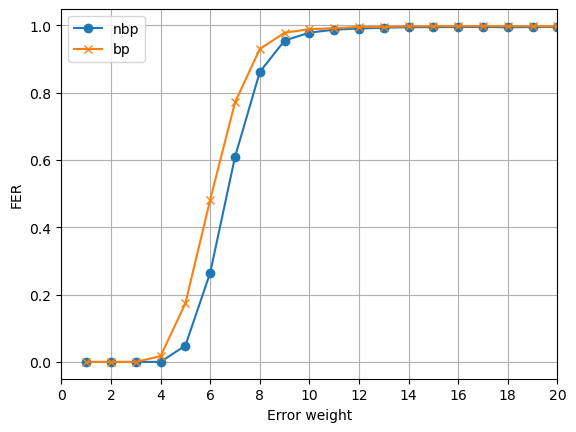

In [ ]:
import matplotlib.ticker as ticker


x = np.array(range(1, 47))
plt.plot(x, fers_nbp_gb, label='nbp', marker='o')
plt.plot(x, fers_bp_gb, label='bp', marker='x')
plt.xlabel('Error weight')
plt.ylabel('FER')
plt.xlim(0, 20)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.grid()
plt.legend()
plt.show()

In [ ]:
n = 32
k = 2
m = 96
codeType = 'toric'

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/" + "fers.pt"

fers_nbp_toric = torch.load(path)
fers_nbp_toric.size()

torch.Size([32])

In [ ]:
n = 32
k = 2
m = 96
codeType = 'toric'

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "_BP_Decoder" + "/" + "fers.pt"

fers_bp_toric = torch.load(path)
fers_bp_toric.size()

torch.Size([32])

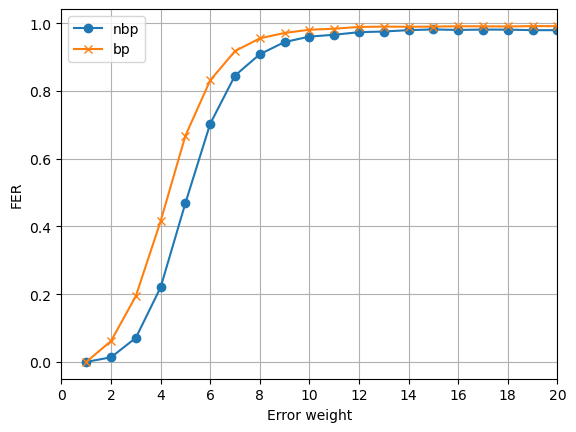

In [ ]:
x = np.array(range(1, 33))
plt.plot(x, fers_nbp_toric, label='nbp', marker='o')
plt.plot(x, fers_bp_toric, label='bp', marker='x')
plt.xlabel('Error weight')
plt.ylabel('FER')
plt.xlim(0, 20)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.grid()
plt.legend()
plt.show()